# Chiplet Analysis

## Tradeoffs associated with yield, chip size, fidelity, and performance are studied to compare chiplet-based multi-chip modules (MCMs) and monolithic architectures for fixed-frequency transmon QPUs. 





In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

import qiskit


import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
from copy import deepcopy
from random import shuffle
from math import floor, ceil

import seaborn as sns
from copy import copy
import collections 
from copy import deepcopy, copy



from qiskit import IBMQ
from qiskit.converters import circuit_to_dag


IBMQ.load_account()

from chiplet_helpers import *
import chiplet_helpers_original as cho
from historical_data_processing_helpers import *

#benchmarks from https://github.com/teaguetomesh/quantum_circuit_generator
from quantum_circuit_generator.generators import gen_supremacy
from quantum_circuit_generator.generators import gen_BV
from quantum_circuit_generator.generators import gen_hwea
from quantum_circuit_generator.generators import gen_adder

#benchmarks from: https://github.com/SupertechLabs/SupermarQ
import supermarq
from supermarq.benchmarks.bit_code import BitCode
from supermarq.benchmarks.hamiltonian_simulation import HamiltonianSimulation
from supermarq.converters import cirq_to_qiskit



provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy147')


/Users/katesmith/opt/anaconda3/envs/supermarqEnv/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
ibmqfactory.load_account:WARNING:2022-08-03 23:00:08,386: Credentials are already in use. The existing account in the session will be replaced.
ibmqfactory.load_account:WARNING:2022-08-03 23:00:14,761: Credentials are already in use. The existing account in the session will be replaced.
ibmqfactory.load_account:WARNING:2022-08-03 23:00:19,244: Credentials are already in use. The existing account in the session will be replaced.


In [283]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.20.2', 'qiskit-aer': '0.10.4', 'qiskit-ignis': '0.7.1', 'qiskit-ibmq-provider': '0.19.1', 'qiskit-aqua': None, 'qiskit': '0.36.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

### Part 1: Clean data taken from IBM Washington.

#### This information will be used to assign on-chip two-qubit gate error values.

In [2]:
e_coupling_map = provider.get_backend('ibm_washington').configuration().coupling_map

e_n_qubits = provider.get_backend('ibm_washington').configuration().n_qubits

eag_processors = {'ibm_washington':{}}
gather_date = '03_22_2022'


eag_processors = load_historical_data(eag_processors,gather_date) 


#uncomment below for deeper clean of data

single_qubit_features = ['readout_length','T1', 'T2','frequency','anharmonicity','readout_error']

eag_processors_clean = clean_data(eag_processors,'cx',coupling_map=e_coupling_map,verbose=False)

for i in single_qubit_features:
    eag_processors_clean = clean_data(eag_processors_clean,'1q_prop',one_q_prop=i,n_qubits=e_n_qubits,verbose=False)


In [3]:
for i in eag_processors: 
    print(f'{i}: \noriginal dataset: {len(eag_processors[i][i].keys())}, clean dataset: {len(eag_processors_clean[i][i].keys())}, %{len(eag_processors_clean[i][i].keys()) /len(eag_processors[i][i].keys())*100}')
          
          

ibm_washington: 
original dataset: 162, clean dataset: 15, %9.25925925925926


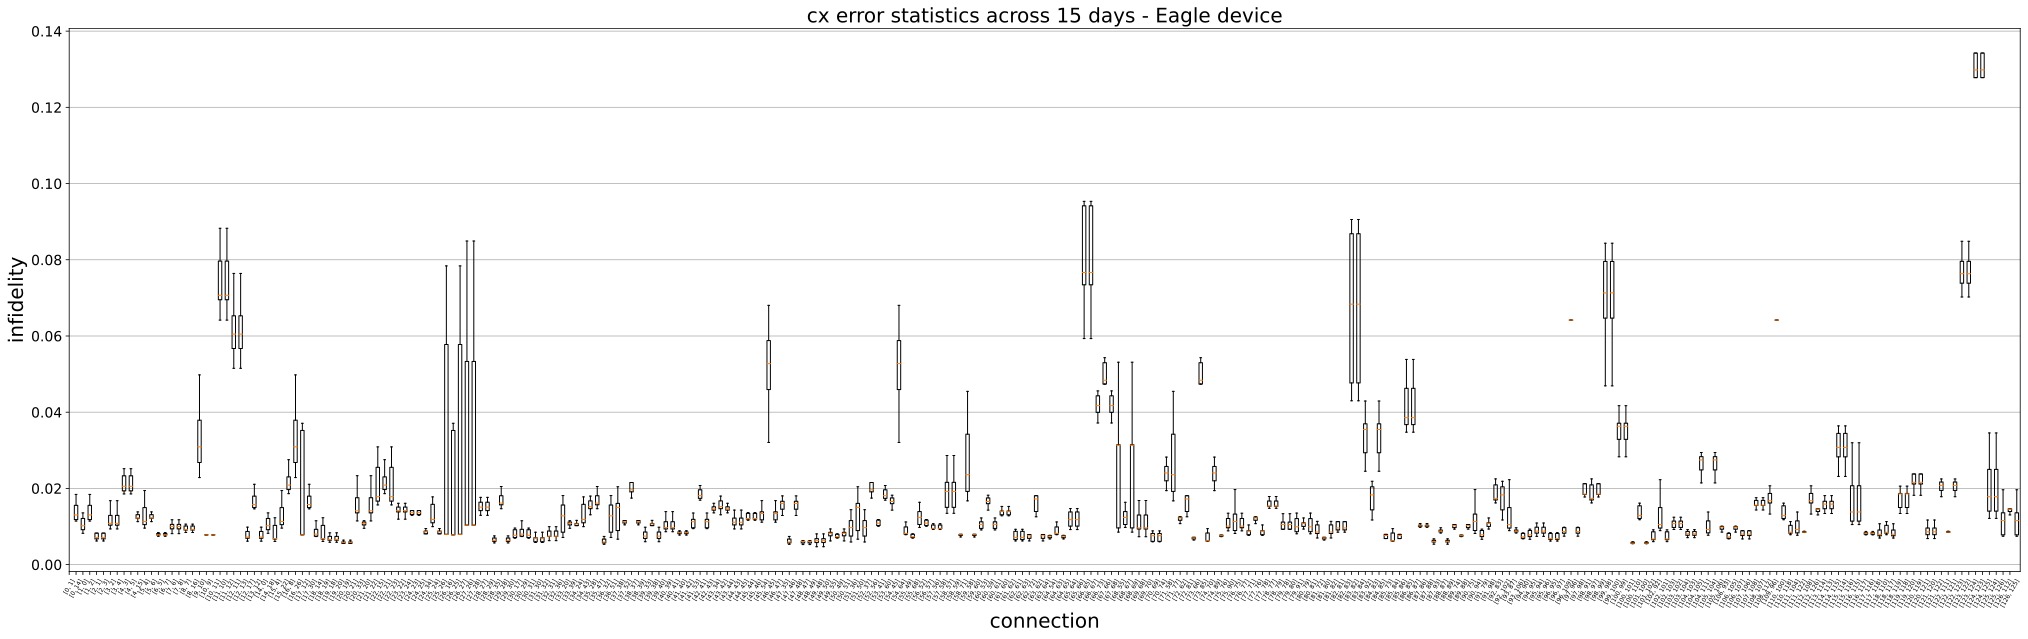

In [4]:
cx_error_e, cx_mean_e, cx_labels_e = isolate_cx_error(eag_processors_clean,e_coupling_map,verbose=False)
q_prop_e, q_prop_mean_e, unit, label_e = isolate_1q_property(n_qubits_e,eag_processors_clean,what_to_analyze='frequency',verbose=False)

columns = []

for i in cx_error_e['ibm_washington'].keys():
    columns.append(cx_error_e['ibm_washington'][i])

fig, ax = plt.subplots(figsize=(35,10))
ax.boxplot(columns,showfliers=False)
ax.set_title(f'cx error statistics across {len(columns[0])} days - Eagle device',fontsize=20)
ax.set_xticks(range(len(cx_error_e['ibm_washington'].keys())))
ax.set_xticklabels(cx_error_e['ibm_washington'].keys(),fontsize=6,rotation=60)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('connection',fontsize=20)
ax.set_ylabel(f'infidelity',fontsize=20)
plt.grid(axis='y')
plt.show()


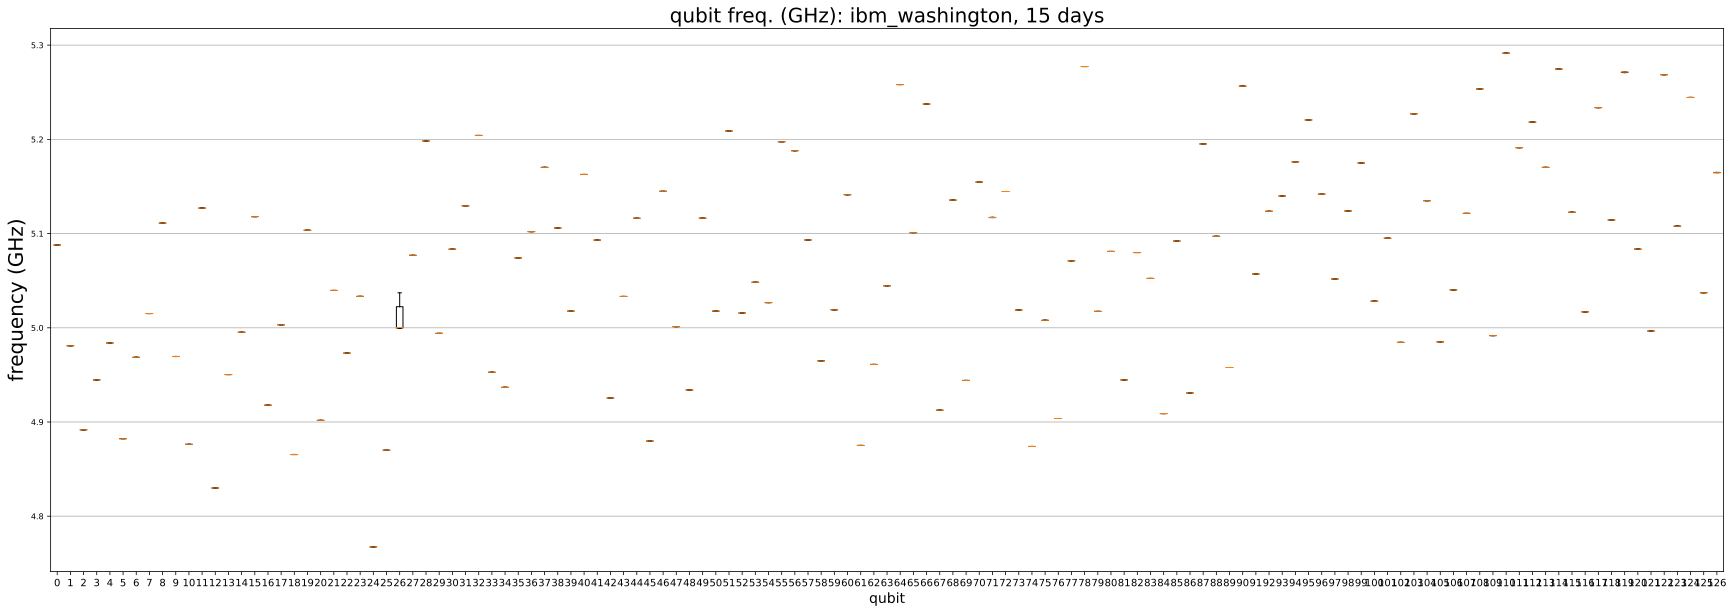

In [5]:
for i in q_prop_e:
    columns = []
    for j in q_prop_e[i]:
        columns.append(q_prop_e[i][j])
    fig, ax = plt.subplots(figsize=(30,10))
    ax.boxplot(columns,showfliers=False)
    ax.set_title(f'qubit freq. (GHz): {i}, {len(columns[0])} days',fontsize=20)
    ax.set_xticklabels(q_prop_e[i].keys(),fontsize=10)
    ax.yaxis.set_tick_params(labelsize=8)
    ax.set_xlabel('qubit',fontsize=14)
    ax.set_ylabel(f'frequency (GHz)',fontsize=20)
    plt.grid(axis='y')

    plt.show()

### Part 2: Create dataset that relates qubit detuning to CX fidelity.

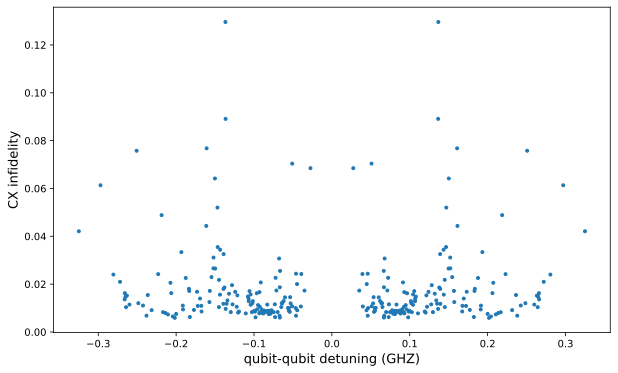

median of 15 day CX mean infidelity: 0.011980526369788212
mean of 15 day CX mean infidelity: 0.018246429441526563


In [6]:
cx_infid_detuning = []

for i in e_coupling_map:
    infid = cx_mean_e['ibm_washington'][str(i)]
    detuning = ((q_prop_mean_e['ibm_washington'][i[0]] - q_prop_mean_e['ibm_washington'][i[1]] ))
    cx_infid_detuning.append([detuning,infid])

cx_infid_detuning.sort()

x_vals = []
y_vals = []

for i in cx_infid_detuning:
    x_vals.append(i[0])
    y_vals.append(i[1])
    

plt.figure(figsize=(10,6))
#plt.ylim([0,0.2])
plt.scatter(x_vals,y_vals, marker='.')
plt.xlabel('qubit-qubit detuning (GHZ)',fontsize=13)
plt.ylabel('CX infidelity',fontsize=13)
plt.show()

print(f'median of 15 day CX mean infidelity: {np.median(y_vals)}')
print(f'mean of 15 day CX mean infidelity: {np.mean(y_vals)}')

### Part 3: Create devices, find collision-free yields, assign error dictionaries, and order chiplets. 

#### We consider chiplets of size 10, 20, 40, 60, 90, 120, 160, 200, and 250 qubits.

In [7]:
# MC simulation details #
###########################################
freq_3 = [5.0, 5.06, 5.12] #GHz
anharmonicity = -0.330 
setting_layout ='heavy_hex_chiplet'
sigma_f = 0.014
n_samples = 10000

###########################################
n_qubits = [10,40,90,160,250]


collision_free_dev = {}
chip_yields = {}

for size_q in n_qubits:
    print(size_q)
    collision_free_dev[size_q] = []
    counter = 0
    for i in range(n_samples):
        temp_dev = simple_qc(setting_layout,size_q,anharmonicity)
        temp_dev.set_coupling_map()
        temp_dev.set_freq_pattern()
        temp_dev.set_ideal_freq_assignment(freq_3)
        temp_dev.set_actual_freq_assignment(sigma_f)
        
        if check_device_freq_collisions(temp_dev,values_used_ideal=False) == False:
            counter = counter + 1
            temp_dev.collision_free = True
            temp_dev.error_dict = return_error_dictionary(temp_dev,cx_infid_detuning)
            collision_free_dev[size_q].append(deepcopy(temp_dev))
    

            
    chip_yields[size_q] = np.round(counter/n_samples,decimals=10)

n_qubits_2 = [20,60,120,200]

for size_q in n_qubits_2:
    print(size_q)
    collision_free_dev[size_q] = []
    counter = 0
    for i in range(n_samples):
        temp_dev = cho.simple_qc(setting_layout,size_q,anharmonicity)
        temp_dev.set_coupling_map()
        temp_dev.set_freq_pattern()
        temp_dev.set_ideal_freq_assignment(freq_3)
        temp_dev.set_actual_freq_assignment(sigma_f)
        
        if cho.check_device_freq_collisions(temp_dev,values_used_ideal=False) == False:
            counter = counter + 1
            temp_dev.collision_free = True
            temp_dev.error_dict = return_error_dictionary(temp_dev,cx_infid_detuning)
            collision_free_dev[size_q].append(deepcopy(temp_dev))
    

            
    chip_yields[size_q] = np.round(counter/n_samples,decimals=10)



10
40
90
160
250
20
60
120
200


In [8]:

collision_free_dev = collections.OrderedDict(sorted(collision_free_dev.items()))
chip_yields = collections.OrderedDict(sorted(chip_yields.items()))
chip_yields

OrderedDict([(10, 0.8527),
             (20, 0.6945),
             (40, 0.4639),
             (60, 0.3116),
             (90, 0.1636),
             (120, 0.0835),
             (160, 0.0377),
             (200, 0.0137),
             (250, 0.0055)])

In [9]:
sorted_chips = {}

for i in collision_free_dev:
    sorted_chips[i] = []
    for j in range(len(collision_free_dev[i])):
        sorted_chips[i].append([collision_free_dev[i][j].return_error_stat(),j])
    sorted_chips[i].sort()

### Part 4: Define chip settings for quantum multi-chip modules (MCMs) under evaluation. All possible configurations of than 500 qubits are included for each chiplet.

#### The variable mcm_dict will hold all important details about the MCMs under evaluation.

In [10]:
mcm_dict = create_mcm_dict(500,chip_yields.keys())

In [11]:
mcm_dict

{10: [{'dim': [2, 1], 'tot_qubits': 20},
  {'dim': [2, 2], 'tot_qubits': 40},
  {'dim': [3, 1], 'tot_qubits': 30},
  {'dim': [3, 2], 'tot_qubits': 60},
  {'dim': [3, 3], 'tot_qubits': 90},
  {'dim': [4, 2], 'tot_qubits': 80},
  {'dim': [4, 3], 'tot_qubits': 120},
  {'dim': [4, 4], 'tot_qubits': 160},
  {'dim': [5, 1], 'tot_qubits': 50},
  {'dim': [5, 2], 'tot_qubits': 100},
  {'dim': [5, 3], 'tot_qubits': 150},
  {'dim': [5, 4], 'tot_qubits': 200},
  {'dim': [5, 5], 'tot_qubits': 250},
  {'dim': [6, 3], 'tot_qubits': 180},
  {'dim': [6, 4], 'tot_qubits': 240},
  {'dim': [6, 5], 'tot_qubits': 300},
  {'dim': [6, 6], 'tot_qubits': 360},
  {'dim': [7, 1], 'tot_qubits': 70},
  {'dim': [7, 2], 'tot_qubits': 140},
  {'dim': [7, 3], 'tot_qubits': 210},
  {'dim': [7, 4], 'tot_qubits': 280},
  {'dim': [7, 5], 'tot_qubits': 350},
  {'dim': [7, 6], 'tot_qubits': 420},
  {'dim': [7, 7], 'tot_qubits': 490},
  {'dim': [8, 4], 'tot_qubits': 320},
  {'dim': [8, 5], 'tot_qubits': 400},
  {'dim': [8, 6]

### Part 5: Create MCMs from collision-free yield. During assembly, check for collisions.

#### If a collision is found, shuffle and try again until timeout.

In [12]:
for i in mcm_dict:
    #print(i)
    for j in mcm_dict[i]:
        #print(str(j['dim']))
        j['mcms'] = []
        chips_in_mcm = j['dim'][0]*j['dim'][1]
        counter = 0
        j['no_mcms_max'] = floor(len(collision_free_dev[i])/chips_in_mcm) 
        for k in range(j['no_mcms_max']):
            single_mcm = []
            
            for m in range(chips_in_mcm):
                single_mcm.append(collision_free_dev[i][sorted_chips[i][counter][1]])
                counter = counter+1
            
            if i in n_qubits_2:
                #do old assembly routines
                assembled_mcm = cho.assemble_single_mcm(j['dim'][0],j['dim'][1],single_mcm)
                assembled_mcm = cho.simple_qc(build_from_dict=True,input_dict=assembled_mcm)
                
                count_mcm_collision_check = 0
                while cho.check_device_freq_collisions(assembled_mcm,values_used_ideal=False) != False:
                    shuffle(single_mcm)
                    assembled_mcm = cho.assemble_single_mcm(j['dim'][0],j['dim'][1],single_mcm)
                    assembled_mcm = cho.simple_qc(build_from_dict=True,input_dict=assembled_mcm)
                    count_mcm_collision_check = count_mcm_collision_check + 1
                    if count_mcm_collision_check == 100:
                        break
                if count_mcm_collision_check == 100:
                    continue
                
                
            else:
            
                assembled_mcm = assemble_single_mcm(j['dim'][0],j['dim'][1],single_mcm)
                assembled_mcm = simple_qc(build_from_dict=True,input_dict=assembled_mcm)
                
                count_mcm_collision_check = 0
                while check_device_freq_collisions(assembled_mcm,values_used_ideal=False) != False:
                    shuffle(single_mcm)
                    assembled_mcm = assemble_single_mcm(j['dim'][0],j['dim'][1],single_mcm)
                    assembled_mcm = simple_qc(build_from_dict=True,input_dict=assembled_mcm)
                    count_mcm_collision_check = count_mcm_collision_check + 1
                    if count_mcm_collision_check == 100:
                        break
                if count_mcm_collision_check == 100:
                    continue
            
            assembled_mcm.collision_free = True
            j['mcms'].append(assembled_mcm)
                
            
            

In [13]:
for i in mcm_dict:
    for j in mcm_dict[i]:
        if j['no_mcms_max'] != len(j['mcms']):
            print(i)
            print('dim: '+str(j['dim']))
            chips_in_mcm = j['dim'][0]*j['dim'][1]
            print('max: %d | mcms actual: %d'% (j['no_mcms_max'],len(j['mcms'])))
            print('chiplets unused: %d'%(len(collision_free_dev[i])-(chips_in_mcm*len(j['mcms']))))
            print()


10
dim: [2, 1]
max: 4263 | mcms actual: 4261
chiplets unused: 5

10
dim: [6, 5]
max: 284 | mcms actual: 281
chiplets unused: 97

10
dim: [6, 6]
max: 236 | mcms actual: 235
chiplets unused: 67

10
dim: [7, 5]
max: 243 | mcms actual: 241
chiplets unused: 92

10
dim: [7, 6]
max: 203 | mcms actual: 197
chiplets unused: 253

10
dim: [7, 7]
max: 174 | mcms actual: 159
chiplets unused: 736

10
dim: [8, 5]
max: 213 | mcms actual: 208
chiplets unused: 207

10
dim: [8, 6]
max: 177 | mcms actual: 168
chiplets unused: 463

10
dim: [9, 5]
max: 189 | mcms actual: 178
chiplets unused: 517

10
dim: [10, 5]
max: 170 | mcms actual: 161
chiplets unused: 477

10
dim: [11, 4]
max: 193 | mcms actual: 188
chiplets unused: 255

10
dim: [13, 3]
max: 218 | mcms actual: 216
chiplets unused: 103

20
dim: [2, 1]
max: 3472 | mcms actual: 3468
chiplets unused: 9

20
dim: [4, 4]
max: 434 | mcms actual: 433
chiplets unused: 17

20
dim: [5, 3]
max: 463 | mcms actual: 462
chiplets unused: 15

20
dim: [5, 5]
max: 277 | m

In [14]:
# double check for no collisions 

for i in mcm_dict:
    for j in mcm_dict[i]:
        for k in j['mcms']:
            
            if check_device_freq_collisions(k,values_used_ideal=False) == True:
                print('collision found')

### Part 6: Create monolithic devices. We want to have one for each MCM size.

In [15]:
mono_yields = {}
mono_collision_free = {}
for i in mcm_dict:
    mono_collision_free[i] = {}
    mono_yields[i] = {}
    #print(i)
    
    for j in mcm_dict[i]:
        tot_qubits = j['tot_qubits']
        #print(f'   {tot_qubits}')
        
        mono_collision_free[i][tot_qubits] = []
        
        counter = 0
        
        for k in range(n_samples):
        
            temp_mono_device = deepcopy(j['mcms'][0])
            temp_mono_device.freq_assignment_actual = None
            temp_mono_device.collision_free = None
            temp_mono_device.error_dict = None
            temp_mono_device.set_actual_freq_assignment(sigma_f)
            
            if check_device_freq_collisions(temp_mono_device,values_used_ideal=False) == False:
                counter = counter + 1
                temp_mono_device.collision_free = True
                temp_mono_device.error_dict = return_error_dictionary(temp_mono_device,cx_infid_detuning)
                mono_collision_free[i][tot_qubits].append(deepcopy(temp_mono_device))
        
        mono_yields[i][tot_qubits] = np.round(counter/n_samples,decimals=10)
                
    

In [16]:
mono_yields

{10: {20: 0.7098,
  40: 0.4597,
  30: 0.5885,
  60: 0.3115,
  90: 0.1561,
  80: 0.2052,
  120: 0.0871,
  160: 0.0342,
  50: 0.4095,
  100: 0.1398,
  150: 0.0458,
  200: 0.0142,
  250: 0.0057,
  180: 0.0236,
  240: 0.0054,
  300: 0.0009,
  360: 0.0005,
  70: 0.286,
  140: 0.0631,
  210: 0.0108,
  280: 0.0023,
  350: 0.0006,
  420: 0.0,
  490: 0.0001,
  320: 0.0015,
  400: 0.0002,
  480: 0.0001,
  270: 0.0032,
  450: 0.0002,
  500: 0.0,
  110: 0.1331,
  220: 0.012,
  330: 0.0011,
  440: 0.0,
  130: 0.092,
  260: 0.0043,
  390: 0.0005,
  170: 0.0458,
  340: 0.0008,
  190: 0.0311,
  380: 0.0003,
  230: 0.0146,
  460: 0.0001,
  290: 0.005,
  310: 0.0035,
  370: 0.0007,
  410: 0.0005,
  430: 0.0005,
  470: 0.0001},
 20: {40: 0.4678,
  80: 0.1932,
  60: 0.305,
  120: 0.083,
  180: 0.0202,
  160: 0.0352,
  240: 0.0065,
  320: 0.0014,
  100: 0.134,
  200: 0.014,
  300: 0.001,
  400: 0.0001,
  500: 0.0002,
  360: 0.0007,
  480: 0.0,
  140: 0.0618,
  280: 0.0029,
  420: 0.0001,
  220: 0.0124,
  4

### Part 7: Analyze tradeoffs between chip size and device infidelity.

#### We will look at MCM configurations that are 'square' and develop a heatmap showing the MCM vs. monolithic ratio of infidelity averaged across every qubit pair.  

In [17]:
#determine number of scaled mcms based on monlithic yield
for i in mcm_dict.keys():
    #print(i)
    for j in mcm_dict[i]:

        #print(j['dim'])

        temp_qubits = j['tot_qubits']
        temp_mono_yield = mono_yields[i][temp_qubits]
        temp_chiplet_yield = chip_yields[i]
        #print('tot mcms: %i'%(len(j['mcms'])))
        #print('tot mono: %i'%(len(mono_collision_free[i][temp_qubits])))

        scaled_chiplet_total = n_samples*temp_mono_yield
        scaled_mcm_total = ceil(scaled_chiplet_total/(j['dim'][0]*j['dim'][1]))
        if scaled_mcm_total == 0:
            scaled_mcm_total = 1
        #print(scaled_mcm_total)
        j['scaled_mcm_total'] = scaled_mcm_total


In [98]:

shapes_of_interest = [[2,2],[3,3],[4,4],[5,5],[6,6],[7,7]]
chiplets_of_interest = [10,20,40,60,90]
heat_map_plot = np.zeros(shape=(len(chiplets_of_interest),len(shapes_of_interest)))


find_fidelity = False
should_scale = True
use_top_threshold = False

threshold_heatmap = 5

for i in chiplets_of_interest:
    print(i)
    for j in mcm_dict[i]:
        if j['dim'] in shapes_of_interest:
            print(j['dim'])
            temp_index = shapes_of_interest.index(j['dim'])
            temp_qubits = j['tot_qubits']
            temp_mono_yield = mono_yields[i][temp_qubits]
            temp_chiplet_yield = chip_yields[i]
            print(len(j['mcms']))
            print(len(mono_collision_free[i][temp_qubits]))
            fid_vals_mcm_temp = []
            fid_vals_mono_temp = []
            for k in j['mcms']:
                if find_fidelity == True:
                    fid_vals_mcm_temp.append((1-k.return_error_stat()))
                else:
                    fid_vals_mcm_temp.append((k.return_error_stat()))
            
            if find_fidelity == True:
                fid_vals_mcm_temp = np.flip(np.sort(fid_vals_mcm_temp))
            else:
                fid_vals_mcm_temp = np.sort(fid_vals_mcm_temp)
            
            for k in mono_collision_free[i][temp_qubits]:
                if find_fidelity == True:
                    fid_vals_mono_temp.append(1-(k.return_error_stat()))
                else: 
                    fid_vals_mono_temp.append(k.return_error_stat())

            if find_fidelity == True:
                fid_vals_mono_temp = np.flip(np.sort(fid_vals_mono_temp))
            else:
                fid_vals_mono_temp = np.sort(fid_vals_mono_temp)

            print(j['scaled_mcm_total'])
            
            if should_scale ==True:
                heat_map_plot[chiplets_of_interest.index(i)][shapes_of_interest.index(j['dim'])] = np.mean(fid_vals_mcm_temp[0:j['scaled_mcm_total']])/np.mean(fid_vals_mono_temp)
                
                if use_top_threshold == True:
                    if len(fid_vals_mono_temp) > threshold_heatmap:
                        heat_map_plot[chiplets_of_interest.index(i)][shapes_of_interest.index(j['dim'])] = np.mean(fid_vals_mcm_temp[0:threshold_heatmap])/np.mean(fid_vals_mono_temp[0:threshold_heatmap])
                    else:
                        heat_map_plot[chiplets_of_interest.index(i)][shapes_of_interest.index(j['dim'])] = np.mean(fid_vals_mcm_temp[0:threshold_heatmap])/np.mean(fid_vals_mono_temp)

            else:
                heat_map_plot[chiplets_of_interest.index(i)][shapes_of_interest.index(j['dim'])] = np.mean(fid_vals_mcm_temp)/np.mean(fid_vals_mono_temp)
            
            
            
        

10
[2, 2]
2131
4597
1150
[3, 3]
947
1561
174
[4, 4]
532
342
22
[5, 5]
341
57
3
[6, 6]
235
5
1
[7, 7]
159
1
1
20
[2, 2]
1736
1932
483
[3, 3]
771
202
23
[4, 4]
433
14
1
[5, 5]
274
2
1
40
[2, 2]
1159
341
86
[3, 3]
515
5
1
60
[2, 2]
779
73
19
90
[2, 2]
409
5
2


[Text(33.0, 0.5, 'chiplet size'), Text(0.5, 15.0, 'MCM dimension')]

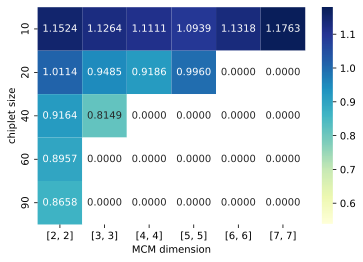

In [99]:

fig, ax = plt.subplots()
my_cmap = copy(plt.cm.YlGnBu)
my_cmap.set_over("white")
my_cmap.set_under("white")
heat_map_plot = np.nan_to_num(heat_map_plot)

sorted_heatmap_info = np.sort(heat_map_plot.flatten())
plot_upper_bound = sorted_heatmap_info[-1]
for i in sorted_heatmap_info:
    if i == 0:
        continue
    else:
        plot_lower_bound = i
        break
im = sns.heatmap(heat_map_plot,xticklabels=shapes_of_interest, yticklabels=chiplets_of_interest,
                 vmin=0.5370927019449213,vmax=1.18,cmap=my_cmap,annot=True, fmt=".4f")
im.set(ylabel='chiplet size',xlabel='MCM dimension')

In [20]:
heat_map_plot

array([[1.15236006, 1.12637347, 1.11106994, 1.09391571, 1.13182663,
        1.1762995 ],
       [1.01143951, 0.94850805, 0.91856041, 0.99600289, 0.        ,
        0.        ],
       [0.91639814, 0.81489885, 0.        , 0.        , 0.        ,
        0.        ],
       [0.89565407, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.86575117, 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

#### Here, we look at interesting MCM shapes.

In [21]:
shapes_of_interest = [[2,1],[3,1],[5,1],[7,1]]
chiplets_of_interest = [10,20,40,60,90]
heat_map_plot = np.zeros(shape=(len(chiplets_of_interest),len(shapes_of_interest)))


find_fidelity = False
should_scale = True
use_top_threshold = False

threshold_heatmap = 5

for i in chiplets_of_interest:
    print(i)
    for j in mcm_dict[i]:
        if j['dim'] in shapes_of_interest:
            print(j['dim'])
            temp_index = shapes_of_interest.index(j['dim'])
            temp_qubits = j['tot_qubits']
            temp_mono_yield = mono_yields[i][temp_qubits]
            temp_chiplet_yield = chip_yields[i]
            print(len(j['mcms']))
            print(len(mono_collision_free[i][temp_qubits]))
            fid_vals_mcm_temp = []
            fid_vals_mono_temp = []
            for k in j['mcms']:
                if find_fidelity == True:
                    fid_vals_mcm_temp.append((1-k.return_error_stat()))
                else:
                    fid_vals_mcm_temp.append((k.return_error_stat()))
            
            if find_fidelity == True:
                fid_vals_mcm_temp = np.flip(np.sort(fid_vals_mcm_temp))
            else:
                fid_vals_mcm_temp = np.sort(fid_vals_mcm_temp)
            
            for k in mono_collision_free[i][temp_qubits]:
                if find_fidelity == True:
                    fid_vals_mono_temp.append(1-(k.return_error_stat()))
                else: 
                    fid_vals_mono_temp.append(k.return_error_stat())

            if find_fidelity == True:
                fid_vals_mono_temp = np.flip(np.sort(fid_vals_mono_temp))
            else:
                fid_vals_mono_temp = np.sort(fid_vals_mono_temp)

            #yield scaling calculations...subject to change
            scaled_chiplet_total = n_samples*temp_mono_yield
            scaled_mcm_total = ceil(scaled_chiplet_total/(j['dim'][0]*j['dim'][1]))
            print(scaled_mcm_total)
            
            if should_scale ==True:
                heat_map_plot[chiplets_of_interest.index(i)][shapes_of_interest.index(j['dim'])] = np.mean(fid_vals_mcm_temp[0:scaled_mcm_total])/np.mean(fid_vals_mono_temp)
                
                if use_top_threshold == True:
                    if len(fid_vals_mono_temp) > threshold_heatmap:
                        heat_map_plot[chiplets_of_interest.index(i)][shapes_of_interest.index(j['dim'])] = np.mean(fid_vals_mcm_temp[0:threshold_heatmap])/np.mean(fid_vals_mono_temp[0:threshold_heatmap])
                    else:
                        heat_map_plot[chiplets_of_interest.index(i)][shapes_of_interest.index(j['dim'])] = np.mean(fid_vals_mcm_temp[0:threshold_heatmap])/np.mean(fid_vals_mono_temp)

            else:
                heat_map_plot[chiplets_of_interest.index(i)][shapes_of_interest.index(j['dim'])] = np.mean(fid_vals_mcm_temp)/np.mean(fid_vals_mono_temp)
            
            
            
        

        

10
[2, 1]
4261
7098
3549
[3, 1]
2842
5885
1962
[5, 1]
1705
4095
819
[7, 1]
1218
2860
409
20
[2, 1]
3468
4678
2339
[3, 1]
2315
3050
1017
[5, 1]
1389
1340
268
[7, 1]
992
618
89
40
[2, 1]
2315
1998
999
[3, 1]
1546
886
296
[5, 1]
927
176
36
[7, 1]
662
42
6
60
[2, 1]
1549
895
448
[3, 1]
1038
244
82
[5, 1]
623
24
5
[7, 1]
445
3
1
90
[2, 1]
816
238
120
[3, 1]
545
29
10
[5, 1]
327
0
0


/Users/katesmith/opt/anaconda3/envs/supermarqEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katesmith/opt/anaconda3/envs/supermarqEnv/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Text(33.0, 0.5, 'chiplet size'), Text(0.5, 15.0, 'MCM dimension')]

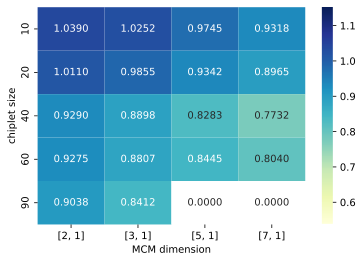

In [22]:

fig, ax = plt.subplots()
my_cmap = copy(plt.cm.YlGnBu)
my_cmap.set_over("white")
my_cmap.set_under("white")
heat_map_plot = np.nan_to_num(heat_map_plot)

sorted_heatmap_info = np.sort(heat_map_plot.flatten())
plot_upper_bound = sorted_heatmap_info[-1]
for i in sorted_heatmap_info:
    if i == 0:
        continue
    else:
        plot_lower_bound = i
        break
im = sns.heatmap(heat_map_plot,xticklabels=shapes_of_interest, yticklabels=chiplets_of_interest,
                 vmin=0.5370927019449213,vmax=1.1520954857446366,cmap=my_cmap,annot=True, fmt=".4f")
im.set(ylabel='chiplet size',xlabel='MCM dimension')

In [23]:
heat_map_plot

array([[1.03896516, 1.0252209 , 0.9745084 , 0.93179168],
       [1.01103457, 0.98547532, 0.934185  , 0.89652063],
       [0.92900035, 0.88978428, 0.828266  , 0.77317729],
       [0.92749039, 0.88069221, 0.84453284, 0.80396472],
       [0.9037588 , 0.84116916, 0.        , 0.        ]])

### Part 8: Sort monolithic collision-free yields. 

In [24]:
sorted_mono= {}


for i in mono_collision_free:
    sorted_mono[i] = {}
    for j in mono_collision_free[i]:
        sorted_mono[i][j] = []
        for k in range(len(mono_collision_free[i][j])):
            sorted_mono[i][j].append([mono_collision_free[i][j][k].return_error_stat(),k])
        sorted_mono[i][j].sort()
        
for i in mcm_dict:
    for j in mcm_dict[i]:
        j['sorted_mcms'] = []
        for k in range(len(j['mcms'])):
            j['sorted_mcms'].append([j['mcms'][k].return_error_stat(),k])
        j['sorted_mcms'].sort()
            

### Part 9: Generate and map benchmarks. 

In [25]:

simple_qc_dict_backends = {'mcm':{},'mono':{}} #pickle for recalling later

my_backends_mcm = {}
for i in mcm_dict:
    my_backends_mcm[i] = {}
    simple_qc_dict_backends['mcm'][i] = {}
    
    for j in mcm_dict[i]:
        tot_qubits_local = j['tot_qubits']
        my_backends_mcm[i][tot_qubits_local] = []
        simple_qc_dict_backends['mcm'][i][tot_qubits_local] = []
        local_error_dict = {}
        
        for k in range(j['scaled_mcm_total']):
            local_index = j['sorted_mcms'][k][-1]
            
            if local_error_dict == {}:
                for item in j['mcms'][local_index].error_dict:
                    local_error_dict[item] = [j['mcms'][local_index].error_dict[item]]
            else:
                for item in j['mcms'][local_index].error_dict:
                    local_error_dict[item].append(j['mcms'][local_index].error_dict[item])
                    
            #simple_qc_dict_backends['mcm'][i][tot_qubits].append(j['mcms'][local_index].to_dict())
            
        for k in local_error_dict:
            local_error_dict[k] = np.mean(local_error_dict[k])
        my_backends_mcm[i][tot_qubits_local].append(create_backend(j['mcms'][0].coupling_map,name=f'my {tot_qubits_local}q MCM',gate_errors=local_error_dict))
        
        temp_simple_qc_dict = j['mcms'][0].to_dict()
        temp_simple_qc_dict['error_dict'] = local_error_dict
        temp_simple_qc_dict['freq_assignment_actual'] = None
        simple_qc_dict_backends['mcm'][i][tot_qubits_local].append(deepcopy(temp_simple_qc_dict))

        
my_backends_mono = {}
for i in mono_collision_free:
    my_backends_mono[i] = {}
    simple_qc_dict_backends['mono'][i] ={}
    
    for j in mono_collision_free[i]:
        tot_qubits_local = j
        my_backends_mono[i][tot_qubits_local] = []
        simple_qc_dict_backends['mono'][i][tot_qubits_local] = []
        local_error_dict = {}
        
        for k in mono_collision_free[i][j]:
            if local_error_dict == {}:
                for item in k.error_dict:
                    local_error_dict[item] = [k.error_dict[item]]
            else:
                for item in k.error_dict:
                    local_error_dict[item].append(k.error_dict[item])
            
            
        for k in local_error_dict:
            local_error_dict[k] = np.mean(local_error_dict[k])
            
        if local_error_dict != {}:
            my_backends_mono[i][tot_qubits_local].append(create_backend(mono_collision_free[i][j][0].coupling_map,name=f'my {tot_qubits_local}q Mono, correspond chip',gate_errors=local_error_dict))
            
            temp_simple_qc_dict = mono_collision_free[i][j][0].to_dict()
            temp_simple_qc_dict['error_dict'] = local_error_dict
            temp_simple_qc_dict['freq_assignment_actual'] = None
            simple_qc_dict_backends['mono'][i][tot_qubits_local].append(deepcopy(temp_simple_qc_dict))

#### Check that all device representations agree.

In [26]:
simple_qc_dict_backends['mono'][20][180][0]['error_dict']['[14, 15]']

0.020090470500873234

In [27]:
little_temp = []
for i in mono_collision_free[20][180]:
    little_temp.append(i.error_dict['[14, 15]'])
np.mean(little_temp)

0.020090470500873234

In [28]:
my_backends_mono[20][180][0].properties().gate_error('cx',[14,15])

0.020090470500873234

In [63]:

bench_qubits = {}

for i in my_backends_mcm:
    bench_qubits[i] = {}
    for j in my_backends_mcm[i]:
        bench_qubits[i][j] = floor(0.8*j) #80 percent device utilization


#****************************************************************

benchmark_type=['bv','ghz','qaoa','adder','prime', 'bit_code','hamiltonian']



basis_gate_lib = ['x', 'sx', 'rz', 'cx', 'id']


In [64]:
benchmark_circs = {}
for i in benchmark_type:
    benchmark_circs[i] = {}
    for j in bench_qubits:
        benchmark_circs[i][j] = {}
        for k in bench_qubits[j]:
            benchmark_circs[i][j][k] = None

In [123]:

for i in bench_qubits:
    for j in bench_qubits[i]:
    
        n_qubits_bench = bench_qubits[i][j]
        print(n_qubits_bench)
        secret_string = ''
        for k in range(n_qubits_bench-1):
            secret_string = secret_string + '1'
        
        benchmark_circs['bv'][i][j] = gen_BV(secret=secret_string)
        benchmark_circs['bv'][i][j]  = transpile(benchmark_circs['bv'][i][j],basis_gates=basis_gate_lib)
        
        benchmark_circs['ghz'][i][j] = QuantumCircuit(n_qubits_bench)
        benchmark_circs['ghz'][i][j].h(0)
        for k in range(1,n_qubits_bench):
            benchmark_circs['ghz'][i][j].cx(k-1,k)
        
        benchmark_circs['qaoa'][i][j] = gen_hwea(width=n_qubits_bench,depth=2)
        benchmark_circs['qaoa'][i][j] = transpile(benchmark_circs['qaoa'][i][j],basis_gates=basis_gate_lib)
        
        benchmark_circs['adder'][i][j] = gen_adder(nbits=(floor((n_qubits_bench-2)/2)))
        benchmark_circs['adder'][i][j] = transpile(benchmark_circs['adder'][i][j],basis_gates=basis_gate_lib)
        
        benchmark_circs['prime'][i][j] = gen_supremacy(1,n_qubits_bench,5)
        benchmark_circs['prime'][i][j]  = transpile(benchmark_circs['prime'][i][j],basis_gates=basis_gate_lib)
        
        temp_qs = n_qubits_bench
        for k in range(2,500):
            temp_circ =cirq_to_qiskit(BitCode(k,1,[1]*k).circuit())
            if temp_qs >= temp_circ.num_qubits and temp_qs-2 < temp_circ.num_qubits:
                print(k)
                print(temp_circ.num_qubits)
                break
        
        
        benchmark_circs['bit_code'][i][j] = temp_circ
        benchmark_circs['bit_code'][i][j] = transpile(benchmark_circs['bit_code'][i][j],basis_gates=basis_gate_lib)
        
        benchmark_circs['hamiltonian'][i][j]  = cirq_to_qiskit(HamiltonianSimulation(n_qubits_bench).circuit())
        benchmark_circs['hamiltonian'][i][j] = transpile(benchmark_circs['hamiltonian'][i][j],basis_gates=basis_gate_lib)

        
        
        
        
    

In [68]:
bench_count = 0
sample_bench = 'ghz'
all_varieties = []
for i in benchmark_circs[sample_bench].keys():
    bench_count = bench_count + len(benchmark_circs[sample_bench][i].keys())
    all_varieties = all_varieties + list(benchmark_circs[sample_bench][i].keys())
        
print('total of each benchmark = %i'%(bench_count))
print('total unique sizes(qubits) for each benchmark = %i'%(len(set(all_varieties))))

total of each benchmark = 102
total unique sizes(qubits) for each benchmark = 49


In [33]:
mapped_circuits = {}

for i in ['mcm','mono']:
    mapped_circuits[i] = {}
    for j in benchmark_type:
        mapped_circuits[i][j] = {}
        for k in my_backends_mcm:
            mapped_circuits[i][j][k] = {}
            for m in my_backends_mcm[k]:
                mapped_circuits[i][j][k][m] = []

In [124]:

for i in benchmark_circs:
    print(i)
    for j in benchmark_circs[i]:
        print(j)
        for k in benchmark_circs[i][j]:
            print(k)
            for m in range(len(my_backends_mcm[j][k])):
                #delete below
                if mapped_circuits['mcm'][i][j][k] == [] and mono_yields[j][k]!= 0:
                    temp_mcm_mapping = transpile(benchmark_circs[i][j][k],my_backends_mcm[j][k][m])
                    mapped_circuits['mcm'][i][j][k].append(temp_mcm_mapping)
                


### Part 10: Find average device performance with benchmarks.

#### To compare MCM and Monolithic devices, a ratio of MCM/Monolithic fidelity will be used.

#### Save mapped circuit data

In [71]:
for device_kind in mapped_circuits:
    for bench in mapped_circuits[device_kind]:
        for size_c in mapped_circuits[device_kind][bench]:
            for n_q in mapped_circuits[device_kind][bench][size_c]:
                for i in range(len(mapped_circuits[device_kind][bench][size_c][n_q])):
                
                    file_name = device_kind+'_'+bench+'_'+str(size_c)+'c_'+str(n_q)+'q_'+str(i)+'.qasm'
                    qasm_file = open(file_name,'w')
                    qasm_file.write(mapped_circuits[device_kind][bench][size_c][n_q][i].qasm())
                    qasm_file.close()

pickle.dump( simple_qc_dict_backends, open( "simple_qc_dict_backends.p", "wb" ) )

#### Analyze data CX fidelity product on critical path as well as fidelity product for entire circuit.

In [72]:
cx_data_critical = {}
cx_data_all = {}

improve_error = False
perc_error = 0.01

for device_kind in mapped_circuits:
    cx_data_critical[device_kind] = {}
    cx_data_all[device_kind] = {}
    
    for bench in mapped_circuits[device_kind]:
        cx_data_critical[device_kind][bench] = {}
        cx_data_all[device_kind][bench] = {}
        
        for size_c in mapped_circuits[device_kind][bench]:
                cx_data_critical[device_kind][bench][size_c] = {}
                cx_data_all[device_kind][bench][size_c] = {}
                
                for n_q in mapped_circuits[device_kind][bench][size_c]:
                    cx_data_critical[device_kind][bench][size_c][n_q] = []
                    cx_data_all[device_kind][bench][size_c][n_q] = []
                    
                 
                    
                    
                    
                    circs_to_gather = len(mapped_circuits['mcm'][bench][size_c][n_q])
                    #remove below
                    if circs_to_gather > 1:
                        circs_to_gather = 1
                    if device_kind == 'mono':
                        if mono_yields[size_c][n_q] == 0:
                            circs_to_gather = 0

                    for i in range(circs_to_gather):
                        temp_dag_all = circuit_to_dag(mapped_circuits['mcm'][bench][size_c][n_q][i])
                        temp_dag = temp_dag_all.longest_path()
                        temp_circ_all = mapped_circuits['mcm'][bench][size_c][n_q][i]
                        
                        
                        if device_kind == 'mcm':
                            for j in mcm_dict[size_c]:
                                if j['tot_qubits'] == n_q:
                                    local_error_dict = simple_qc_dict_backends['mcm'][size_c][n_q][i]['error_dict']
                        
                        if device_kind == 'mono':
                            local_error_dict = simple_qc_dict_backends['mono'][size_c][n_q][i]['error_dict']
                            
                        fidelity = 1
                        for operation in temp_dag:
                            if operation.name == 'cx':
                                q_args = operation.qargs
                                q_index = [q_args[0].index,q_args[1].index]
                                if improve_error ==True:
                                    local_fid = 1- local_error_dict[str(q_index)]*perc_error
                                else:
                                    local_fid = 1- local_error_dict[str(q_index)]
                                fidelity = fidelity*local_fid
                        cx_data_critical[device_kind][bench][size_c][n_q].append(fidelity)
                        
                        fidelity = 1
                        for operation in temp_circ_all:
                            if operation[0].name == 'cx':
                                q_args = operation[1]
                                q_index = [q_args[0].index,q_args[1].index]
                                if improve_error ==True:
                                    local_fid = 1- local_error_dict[str(q_index)]*perc_error
                                else:
                                    local_fid = 1- local_error_dict[str(q_index)]
                                fidelity = fidelity*local_fid
                        cx_data_all[device_kind][bench][size_c][n_q].append(fidelity)
                        



/var/folders/ht/3ysn5md93z3fgzl5kn2p5dwc0000gn/T/ipykernel_3681/1496484785.py:60: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q_index = [q_args[0].index,q_args[1].index]
/var/folders/ht/3ysn5md93z3fgzl5kn2p5dwc0000gn/T/ipykernel_3681/1496484785.py:72: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q_index = [q_args[0].index,q_args[1].index]


In [73]:
cx_data_all

{'mcm': {'bv': {10: {20: [0.006779850025501001],
    40: [1.1861060933314288e-05],
    30: [0.012539570755932868],
    60: [2.321643401746219e-06],
    90: [1.5245619116750006e-10],
    80: [7.079583942951108e-08],
    120: [1.890965105564013e-14],
    160: [6.004544856146398e-26],
    50: [9.480927842319387e-06],
    100: [8.842554748662054e-11],
    150: [2.357722153788711e-21],
    200: [3.6266451346083094e-33],
    250: [1.124355146263754e-57],
    180: [2.263493809468935e-50],
    240: [1.0536650169341427e-51],
    300: [4.1533069688324726e-66],
    360: [8.9500163284757e-89],
    70: [4.486657349054784e-05],
    140: [4.802231181311685e-24],
    210: [7.468628235147326e-24],
    280: [1.235108299118944e-34],
    350: [5.380609179517585e-156],
    420: [],
    490: [2.465194285703021e-114],
    320: [1.4936785893731876e-48],
    400: [3.105528969224549e-84],
    480: [1.0507299302415202e-145],
    270: [2.4769760629280154e-29],
    450: [2.792981493944187e-92],
    500: [],
    11

In [74]:
cx_data_critical

{'mcm': {'bv': {10: {20: [0.04379663402547372],
    40: [0.0007250077383965759],
    30: [0.07918840773153572],
    60: [0.0003684522889612064],
    90: [6.113090684669134e-06],
    80: [8.752784569904106e-05],
    120: [1.45465368685343e-08],
    160: [1.9339067819097105e-14],
    50: [0.001266800460806124],
    100: [1.523084061298386e-06],
    150: [2.6532861422338832e-12],
    200: [1.1379197716259798e-17],
    250: [5.86217138078451e-32],
    180: [5.951441458082037e-27],
    240: [1.2982651195784312e-27],
    300: [5.5428521510066775e-34],
    360: [1.2700595724081465e-44],
    70: [0.001709464363095249],
    140: [3.3744440665098236e-13],
    210: [1.7814435222294323e-13],
    280: [2.040438492566186e-18],
    350: [5.422843285524909e-81],
    420: [],
    490: [5.6578317384762694e-58],
    320: [1.712990419395745e-25],
    400: [2.5951870158329854e-47],
    480: [4.934245964540008e-78],
    270: [6.925129780535991e-16],
    450: [1.396810790744001e-48],
    500: [],
    110: [0

In [75]:
pickle.dump( cx_data_critical, open( "cx_data_critical.p", "wb" ) )
pickle.dump( cx_data_all, open( "cx_data_all.p", "wb" ) )

In [76]:
cx_data_to_examine = cx_data_all

y_data = {}
x_data = {}

for item in benchmark_type:
    bench_type = item
    y_data[bench_type] = {}
    x_data[bench_type] = {}


    for i in ['mcm','mono']:
        y_data[bench_type][i] = {}
        x_data[bench_type][i] = {}
        for j in cx_data_to_examine[i][item]:
            y_data[bench_type][i][j] = []
            x_data[bench_type][i][j] = []
            for k in cx_data_to_examine[i][item][j]:
                if cx_data_to_examine[i][item][j][k] != []:
                    y_data[bench_type][i][j].append((max(cx_data_to_examine[i][item][j][k])))
                    x_data[bench_type][i][j].append(k)
        
   


In [77]:
x_data

{'bv': {'mcm': {10: [20,
    40,
    30,
    60,
    90,
    80,
    120,
    160,
    50,
    100,
    150,
    200,
    250,
    180,
    240,
    300,
    360,
    70,
    140,
    210,
    280,
    350,
    490,
    320,
    400,
    480,
    270,
    450,
    110,
    220,
    330,
    130,
    260,
    390,
    170,
    340,
    190,
    380,
    230,
    460,
    290,
    310,
    370,
    410,
    430,
    470],
   20: [40,
    80,
    60,
    120,
    180,
    160,
    240,
    320,
    100,
    200,
    300,
    400,
    500,
    360,
    140,
    280,
    420,
    220,
    260,
    340,
    380,
    460],
   40: [80, 160, 120, 240, 360, 320, 200, 400, 280, 440],
   60: [120, 240, 180, 360, 300, 420],
   90: [180, 360, 270],
   120: [240, 360],
   160: [320],
   200: [],
   250: [500]},
  'mono': {10: [20,
    40,
    30,
    60,
    90,
    80,
    120,
    160,
    50,
    100,
    150,
    200,
    250,
    180,
    240,
    300,
    360,
    70,
    140,
    210,
    280,

In [78]:
y_data

{'bv': {'mcm': {10: [0.006779850025501001,
    1.1861060933314288e-05,
    0.012539570755932868,
    2.321643401746219e-06,
    1.5245619116750006e-10,
    7.079583942951108e-08,
    1.890965105564013e-14,
    6.004544856146398e-26,
    9.480927842319387e-06,
    8.842554748662054e-11,
    2.357722153788711e-21,
    3.6266451346083094e-33,
    1.124355146263754e-57,
    2.263493809468935e-50,
    1.0536650169341427e-51,
    4.1533069688324726e-66,
    8.9500163284757e-89,
    4.486657349054784e-05,
    4.802231181311685e-24,
    7.468628235147326e-24,
    1.235108299118944e-34,
    5.380609179517585e-156,
    2.465194285703021e-114,
    1.4936785893731876e-48,
    3.105528969224549e-84,
    1.0507299302415202e-145,
    2.4769760629280154e-29,
    2.792981493944187e-92,
    3.48808966486095e-07,
    1.2999660443340284e-18,
    4.318584418278426e-132,
    1.9086463260991324e-08,
    5.38247800451194e-24,
    1.6406123417928186e-42,
    6.13484944182921e-11,
    4.894113276129385e-26,
   

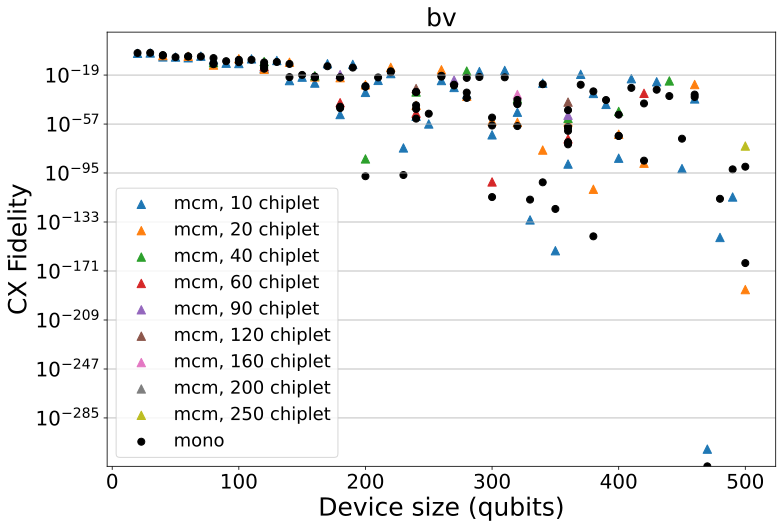

In [80]:
bench= 'bv'
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in y_data[bench]:
    for j in y_data[bench][i]:
        if i == 'mcm':
            ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=70, marker='^', label=f'{i}, {j} chiplet')
        else:
            if j == list(y_data[bench][i].keys())[0]:
                ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=50, color='black' ,label=f'{i}')
            else:
                ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=50, color='black' )
                
                
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('CX Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
plt.legend(loc='lower left',fontsize=18)
plt.yscale('log')
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.show()

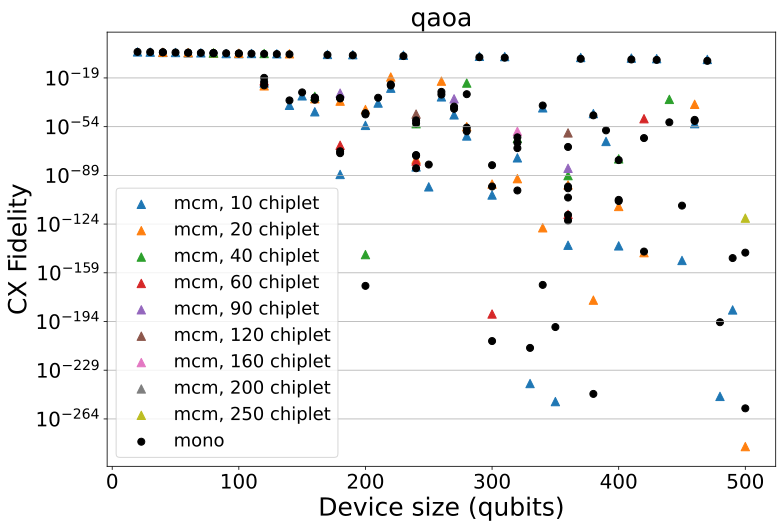

In [82]:
bench= 'qaoa'
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in y_data[bench]:

    for j in y_data[bench][i]:

        if i == 'mcm':
            ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=70, marker='^', label=f'{i}, {j} chiplet')
        else:
            if j == list(y_data[bench][i].keys())[0]:
                ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=50, color='black' ,label=f'{i}')
            else:
                ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=50, color='black' )
                
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('CX Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
plt.legend(loc='lower left',fontsize=18)
plt.yscale('log')
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.show()

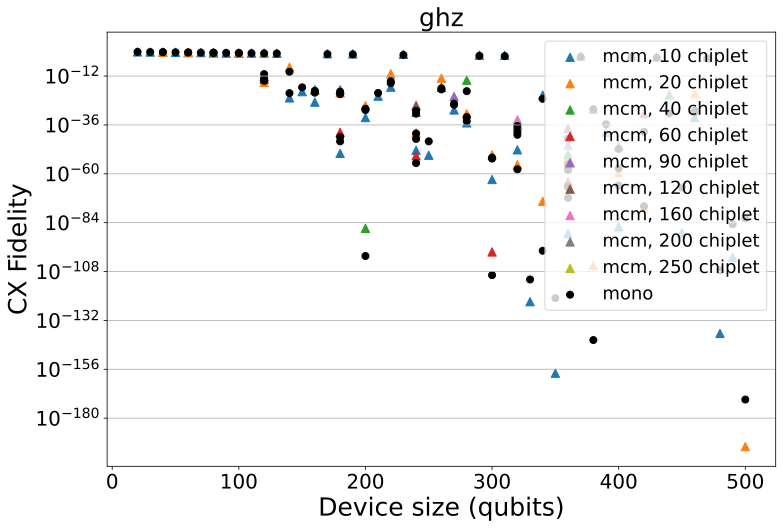

In [83]:
bench= 'ghz'
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in y_data[bench]:
    for j in y_data[bench][i]:
        if i == 'mcm':
            ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=70, marker='^', label=f'{i}, {j} chiplet')
        else:
            if j == list(y_data[bench][i].keys())[0]:
                ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=50, color='black' ,label=f'{i}')
            else:
                ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=50, color='black' )
                
                
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('CX Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
plt.legend(loc='upper right',fontsize=18)
plt.yscale('log')
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.show()

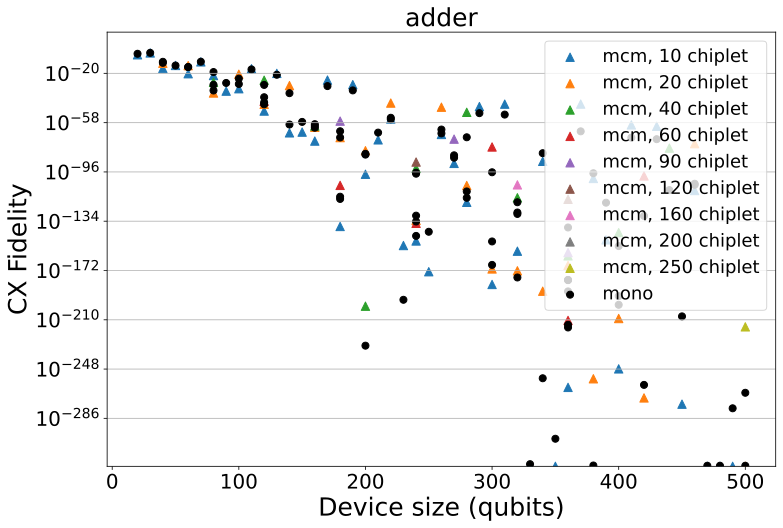

In [84]:
bench= 'adder'
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in y_data[bench]:
    for j in y_data[bench][i]:
        if i == 'mcm':
            ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=70, marker='^', label=f'{i}, {j} chiplet')
        else:
            if j == list(y_data[bench][i].keys())[0]:
                ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=50, color='black' ,label=f'{i}')
            else:
                ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=50, color='black' )
                
                
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('CX Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
plt.legend(loc='upper right',fontsize=18)
plt.yscale('log')
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.show()

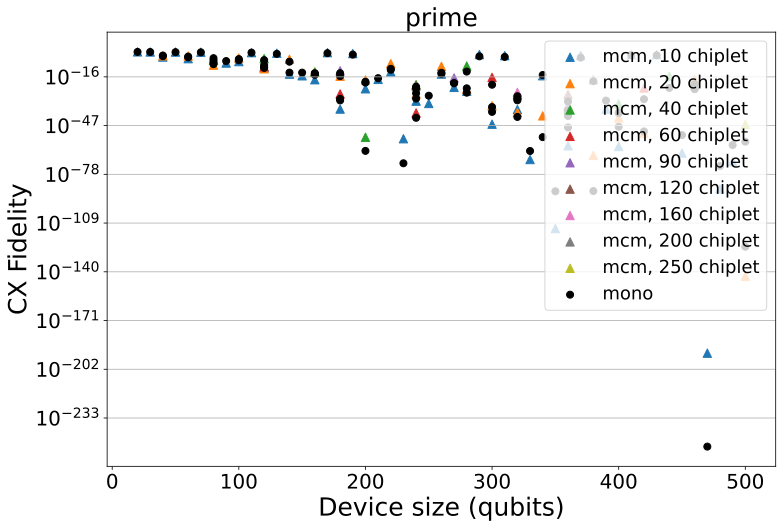

In [85]:
bench= 'prime'
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in y_data[bench]:
    for j in y_data[bench][i]:
        if i == 'mcm':
            ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=70, marker='^', label=f'{i}, {j} chiplet')
        else:
            if j == list(y_data[bench][i].keys())[0]:
                ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=50, color='black' ,label=f'{i}')
            else:
                ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=50, color='black' )
                
                
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('CX Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
plt.legend(loc='upper right',fontsize=18)
plt.yscale('log')
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.show()

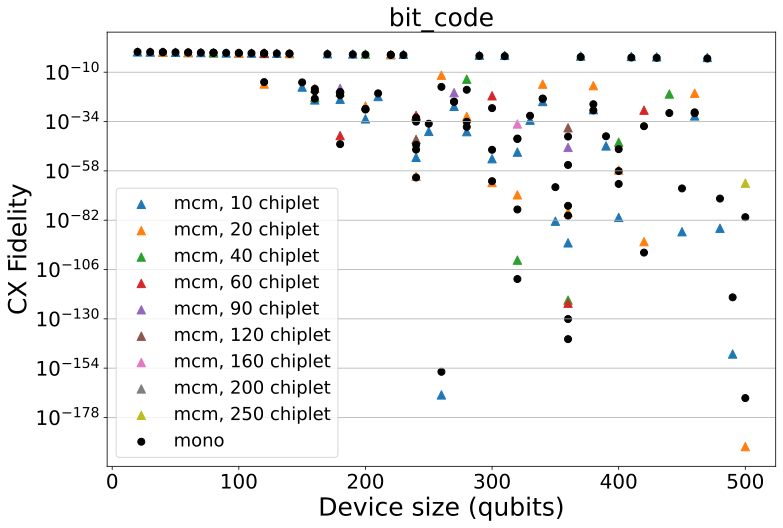

In [87]:
bench= 'bit_code'
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in y_data[bench]:

    for j in y_data[bench][i]:

        if i == 'mcm':
            ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=70, marker='^', label=f'{i}, {j} chiplet')
        else:
            if j == list(y_data[bench][i].keys())[0]:
                ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=50, color='black' ,label=f'{i}')
            else:
                ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=50, color='black' )
                
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('CX Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
plt.legend(loc='lower left',fontsize=18)
plt.yscale('log')
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.show()

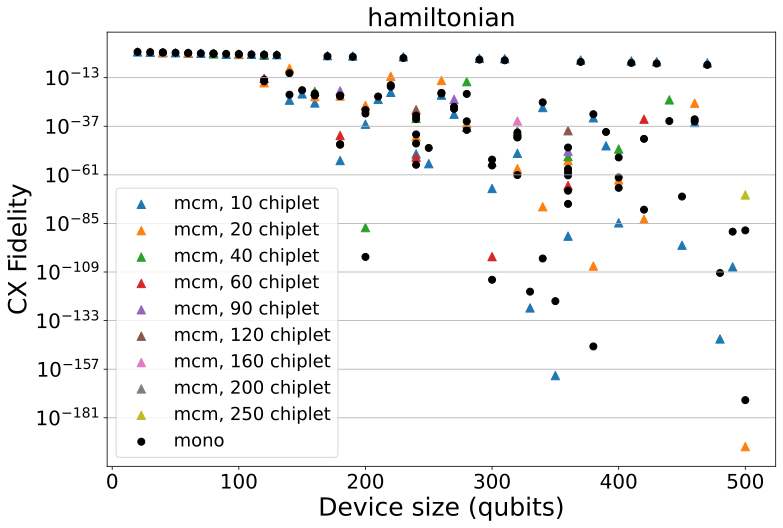

In [88]:
bench= 'hamiltonian'
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for i in y_data[bench]:

    for j in y_data[bench][i]:

        if i == 'mcm':
            ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=70, marker='^', label=f'{i}, {j} chiplet')
        else:
            if j == list(y_data[bench][i].keys())[0]:
                ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=50, color='black' ,label=f'{i}')
            else:
                ax.scatter(x_data[bench][i][j], y_data[bench][i][j], s=50, color='black' )
                
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('CX Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
plt.legend(loc='lower left',fontsize=18)
plt.yscale('log')
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.show()

In [89]:
#cost per qubit
xy_data_mono = []
xy_data_mcm = {}


for i in mono_yields:
    xy_data_mcm[i] = []
    for j in mono_yields[i]:
        if mono_yields[i][j] != 0 :
            xy_data_mono.append([j,j/mono_yields[i][j]])
        if chip_yields[i]!=0:
            xy_data_mcm[i].append([j,(j/i)*i/chip_yields[i]])
    xy_data_mcm[i].sort()
        
xy_data_mono.sort()

In [90]:
x_yield_mono = []
y_yield_mono = []
for i in range(len(xy_data_mono)):
    x_yield_mono.append(xy_data_mono[i][0])
    y_yield_mono.append(xy_data_mono[i][1])
    
x_yield_mcm = {}
y_yield_mcm = {}
for j in xy_data_mcm:
    x_yield_mcm[j] = []
    y_yield_mcm[j] = []
    for i in range(len(xy_data_mcm[j])):
        x_yield_mcm[j].append(xy_data_mcm[j][i][0])
        y_yield_mcm[j].append(xy_data_mcm[j][i][1])
    
    

/var/folders/ht/3ysn5md93z3fgzl5kn2p5dwc0000gn/T/ipykernel_3681/2254971303.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,10**6])


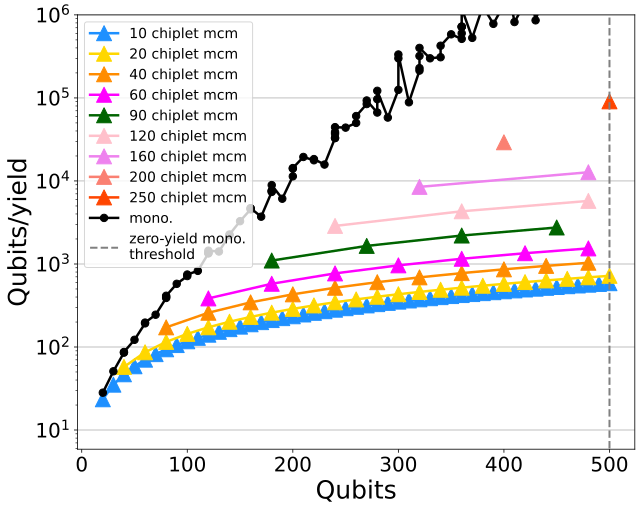

In [91]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
color_guide = {10:'dodgerblue',20:'gold',40:'darkorange',60:'magenta',90:'darkgreen',120:'pink',160:'violet',200:'salmon',250:'orangered'}


for i in y_yield_mcm:
    ax.plot(x_yield_mcm[i],y_yield_mcm[i], marker='^', markersize=15,linewidth=2.5,color = color_guide[i],label=f'{i} chiplet mcm')
               
        
ax.plot(x_yield_mono, y_yield_mono, marker='.',color='black',linewidth=2.5, markersize =15,label=f'mono.')
ax.plot([max(x_yield_mono),max(x_yield_mono)],[0,max(y_yield_mono)**2], '--',linewidth=2,color='gray',label='zero-yield mono.\nthreshold')
                
#plt.title(f'Qubit/yield',fontsize=25)
ax.set_ylabel('Qubits/yield',fontsize=25)
ax.set_xlabel('Qubits',fontsize=25)
plt.legend(loc='upper left',fontsize=14)
plt.yscale('log')
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
plt.ylim([0,10**6])
ax.grid(axis='y')
plt.show()

In [92]:
cx_data_to_examine = cx_data_all

#y_data = {}
#x_data = {}

ratio_data = {}
ratio_x_vals = {}
lines_no_mono = {}

for item in benchmark_type:
    bench_type = item
    ratio_data[bench_type] = {}
    ratio_x_vals[bench_type] = {}
    lines_no_mono[bench_type] = {}



        
    for j in cx_data_to_examine['mcm'][item]:
        ratio_data[bench_type][j] = []
        ratio_x_vals[bench_type][j] = []
        lines_no_mono[bench_type][j] = []
            
        for k in cx_data_to_examine['mcm'][item][j]:
            if cx_data_to_examine['mcm'][item][j][k] != []:
                ratio_data[bench_type][j].append(cx_data_to_examine['mcm'][item][j][k][0]/cx_data_to_examine['mono'][item][j][k][0])
                ratio_x_vals[bench_type][j].append(k)
            else:
                lines_no_mono[bench_type][j].append(k)
                    
        

In [93]:
ratio_data

{'bv': {10: [0.5465792105875465,
   0.0907458365039232,
   0.7211100515621943,
   0.08236664682189429,
   0.026355965552192783,
   0.04718907285438822,
   0.004775499366278741,
   4.875449356159209e-05,
   1.2048436799424835,
   0.08833916546277523,
   0.018207888771883687,
   1.2475940798429385e-05,
   1.0450524784707458e-08,
   7.356307198634882e-07,
   2.009035975643393e-06,
   3.971696786384852e-14,
   5.382352378141872e-16,
   1.83054806782053,
   0.0019330641836791337,
   0.005390910221048036,
   0.04721189692177303,
   3.846405437518736e-33,
   3.437255253543104e-22,
   4.670501850813863e-07,
   5.474480634527601e-18,
   1.0193027460477283e-30,
   0.007086771260348891,
   6.4619133297498796e-24,
   5.018259802923081,
   0.01651255178363586,
   1.7995489470243477e-16,
   13.665319544183674,
   0.00019619125112975988,
   0.0003881256317886915,
   91.29077348658737,
   6.502625455141205,
   313.9497401493239,
   0.023196122083414383,
   1.0201902881097056e+21,
   0.0282511118731776

In [94]:
ratio_x_vals

{'bv': {10: [20,
   40,
   30,
   60,
   90,
   80,
   120,
   160,
   50,
   100,
   150,
   200,
   250,
   180,
   240,
   300,
   360,
   70,
   140,
   210,
   280,
   350,
   490,
   320,
   400,
   480,
   270,
   450,
   110,
   220,
   330,
   130,
   260,
   390,
   170,
   340,
   190,
   380,
   230,
   460,
   290,
   310,
   370,
   410,
   430,
   470],
  20: [40,
   80,
   60,
   120,
   180,
   160,
   240,
   320,
   100,
   200,
   300,
   400,
   500,
   360,
   140,
   280,
   420,
   220,
   260,
   340,
   380,
   460],
  40: [80, 160, 120, 240, 360, 320, 200, 400, 280, 440],
  60: [120, 240, 180, 360, 300, 420],
  90: [180, 360, 270],
  120: [240, 360],
  160: [320],
  200: [],
  250: [500]},
 'ghz': {10: [20,
   40,
   30,
   60,
   90,
   80,
   120,
   160,
   50,
   100,
   150,
   200,
   250,
   180,
   240,
   300,
   360,
   70,
   140,
   210,
   280,
   350,
   490,
   320,
   400,
   480,
   270,
   450,
   110,
   220,
   330,
   130,
   260,
   390,

In [95]:
lines_no_mono

{'bv': {10: [420, 500, 440],
  20: [480, 440],
  40: [480],
  60: [480],
  90: [450],
  120: [480],
  160: [480],
  200: [400],
  250: []},
 'ghz': {10: [420, 500, 440],
  20: [480, 440],
  40: [480],
  60: [480],
  90: [450],
  120: [480],
  160: [480],
  200: [400],
  250: []},
 'qaoa': {10: [420, 500, 440],
  20: [480, 440],
  40: [480],
  60: [480],
  90: [450],
  120: [480],
  160: [480],
  200: [400],
  250: []},
 'adder': {10: [420, 500, 440],
  20: [480, 440],
  40: [480],
  60: [480],
  90: [450],
  120: [480],
  160: [480],
  200: [400],
  250: []},
 'prime': {10: [420, 500, 440],
  20: [480, 440],
  40: [480],
  60: [480],
  90: [450],
  120: [480],
  160: [480],
  200: [400],
  250: []},
 'bit_code': {10: [420, 500, 440],
  20: [480, 440],
  40: [480],
  60: [480],
  90: [450],
  120: [480],
  160: [480],
  200: [400],
  250: []},
 'hamiltonian': {10: [420, 500, 440],
  20: [480, 440],
  40: [480],
  60: [480],
  90: [450],
  120: [480],
  160: [480],
  200: [400],
  250: [

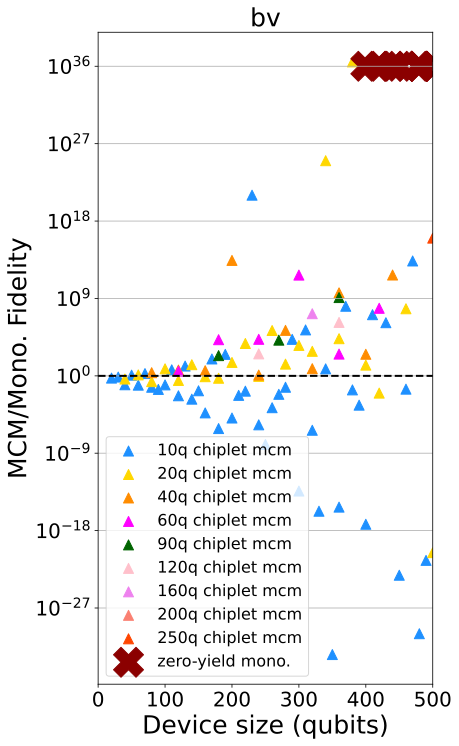

3.550507932113426e+34

In [272]:
bench= 'bv'
y_axis_bounds = [0.8,10**36]
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(111)
all_data = []
count = 0
for i in ratio_data[bench]:
    ax.scatter(ratio_x_vals[bench][i],ratio_data[bench][i],  s=100, marker='^', color = color_guide[i],label=f'{i}q chiplet mcm')

    all_data = all_data+ratio_data[bench][i]
    count=count+1

ax.plot([0,500],[1,1],'--',linewidth=2,color='black')


visited_before = []
one_label = False
for i in lines_no_mono[bench]:
    for j in lines_no_mono[bench][i]:
        if one_label==False:
            ax.scatter([j],[y_axis_bounds[1]],s=900,marker='X',color='darkred',label='zero-yield mono.')
            one_label=True
            visited_before.append(j)
        else:
            move_marker = visited_before.count(j)
            ax.scatter([j],[y_axis_bounds[1]-y_axis_bounds[1]*0.003*move_marker],s=900,marker='X',color='darkred')  
            visited_before.append(j)
            
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('MCM/Mono. Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
plt.legend(loc='lower left',fontsize=16)
plt.yscale('log')
#plt.ylim(y_axis_bounds)
plt.xlim([0,500])
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.savefig('bv-all.jpg',bbox_inches = "tight")
plt.show()
np.mean(all_data)

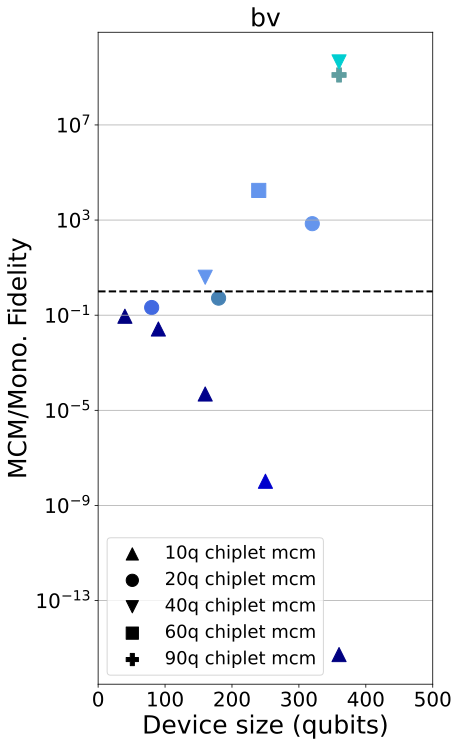

/Users/katesmith/opt/anaconda3/envs/supermarqEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katesmith/opt/anaconda3/envs/supermarqEnv/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [293]:
shapes_of_interest = [[2,2],[3,3],[4,4],[5,5],[6,6],[7,7]]
chiplets_of_interest = [10,20,40,60,90]
chip_shapes = {10:'^',20:'o',40:'v',60:'s',90:'P'}
colors_heat = {10:['navy','darkblue','darkblue','mediumblue','navy','midnightblue'],
               20:['royalblue','steelblue','cornflowerblue','royalblue'],
               40:['cornflowerblue','darkturquoise'],
               60:['cornflowerblue'],
               90:['cadetblue']}

bench= 'bv'
y_axis_bounds = [0.8,10**17]
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(111)
all_data = []
for i in shapes_of_interest:
    #print(i)
    for j in chiplets_of_interest:
        if i == [5,5] and j == 20:
            continue
        if i == [7,7] and j == 10:
            continue
        #print(j)
        tot_qubits_local = i[0]*i[1]*j
        #print(tot_qubits_local)
        if tot_qubits_local in cx_data_all['mono'][bench][j].keys():
            if cx_data_all['mono'][bench][j][tot_qubits_local] != []:
                loc_ratio = cx_data_all['mcm'][bench][j][tot_qubits_local][0]/cx_data_all['mono'][bench][j][tot_qubits_local][0]
                ax.scatter(tot_qubits_local,loc_ratio,  s=200, marker=chip_shapes[j], color = colors_heat[j][i[0]-2])
                
for i in chiplets_of_interest:
    ax.scatter([],[],  s=150, marker=chip_shapes[i], color = 'k',label=f'{i}q chiplet mcm')



ax.plot([0,500],[1,1],'--',linewidth=2,color='black')



            
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('MCM/Mono. Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
plt.legend(loc='lower left',fontsize=18)
plt.yscale('log')
#plt.ylim(y_axis_bounds)
plt.xlim([0,500])
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.savefig('bv-focused.jpg',bbox_inches = "tight")
plt.show()
np.mean(all_data)


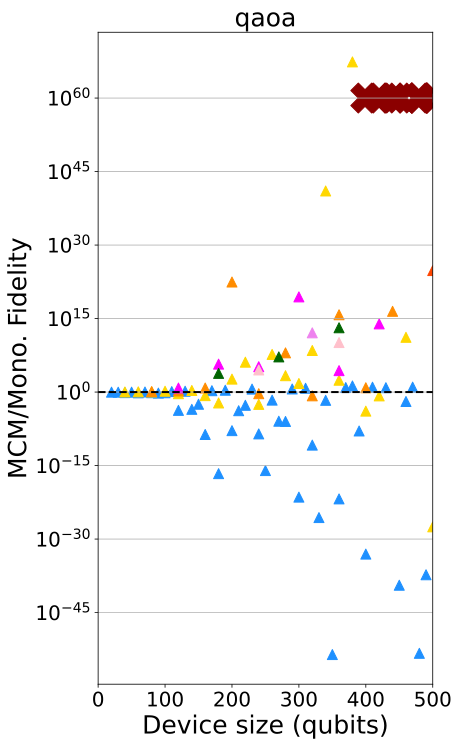

2.600670789546195e+65

In [259]:
bench= 'qaoa'
y_axis_bounds = [0.7,10**60]
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(111)
all_data = []
count = 0
for i in ratio_data[bench]:
    ax.scatter(ratio_x_vals[bench][i],ratio_data[bench][i],  s=100, marker='^', color = color_guide[i],label=f'{i} chiplet mcm')
    all_data = all_data+ratio_data[bench][i]
    count=count+1

ax.plot([0,500],[1,1],'--',linewidth=2,color='black')

visited_before = []
one_label = False
for i in lines_no_mono[bench]:
    for j in lines_no_mono[bench][i]:
        if one_label==False:
            ax.scatter([j],[y_axis_bounds[1]],s=900,marker='X',color='darkred',label='zero-yield mono.')
            one_label=True
            visited_before.append(j)
        else:
            move_marker = visited_before.count(j)
            ax.scatter([j],[y_axis_bounds[1]-y_axis_bounds[1]*0.007*move_marker],s=900,marker='X',color='darkred')  
            visited_before.append(j)
            
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('MCM/Mono. Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
#plt.legend(loc='upper left',fontsize=14)
plt.yscale('log')
#plt.ylim(y_axis_bounds)
plt.xlim([0,500])
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.savefig('qaoa-all.jpg',bbox_inches = "tight")
plt.show()
np.mean(all_data)

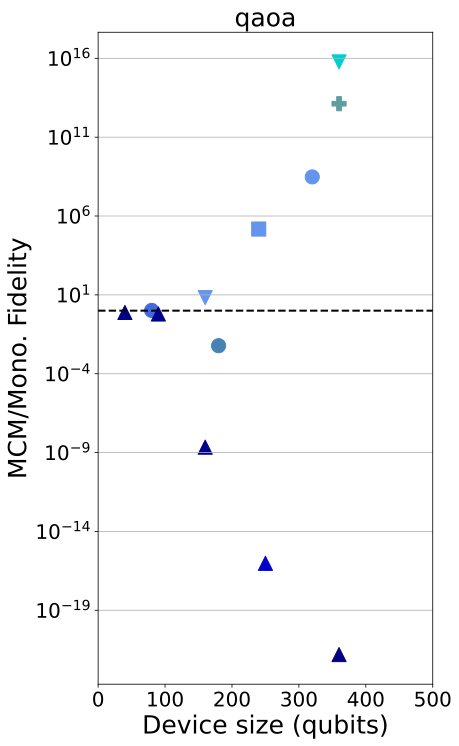

nan

In [294]:
shapes_of_interest = [[2,2],[3,3],[4,4],[5,5],[6,6],[7,7]]
chiplets_of_interest = [10,20,40,60,90]
chip_shapes = {10:'^',20:'o',40:'v',60:'s',90:'P'}
colors_heat = {10:['navy','darkblue','darkblue','mediumblue','navy','midnightblue'],
               20:['royalblue','steelblue','cornflowerblue','royalblue'],
               40:['cornflowerblue','darkturquoise'],
               60:['cornflowerblue'],
               90:['cadetblue']}

bench= 'qaoa'
y_axis_bounds = [0.8,10**17]
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(111)
all_data = []
for i in shapes_of_interest:
    #print(i)
    for j in chiplets_of_interest:
        if i == [5,5] and j == 20:
            continue
        if i == [7,7] and j == 10:
            continue
        #print(j)
        tot_qubits_local = i[0]*i[1]*j
        #print(tot_qubits_local)
        if tot_qubits_local in cx_data_all['mono'][bench][j].keys():
            if cx_data_all['mono'][bench][j][tot_qubits_local] != []:
                loc_ratio = cx_data_all['mcm'][bench][j][tot_qubits_local][0]/cx_data_all['mono'][bench][j][tot_qubits_local][0]
                ax.scatter(tot_qubits_local,loc_ratio,  s=200, marker=chip_shapes[j], color = colors_heat[j][i[0]-2])
                
for i in chiplets_of_interest:
    ax.scatter([],[],  s=150, marker=chip_shapes[i], color = 'k',label=f'{i}q chiplet mcm')



ax.plot([0,500],[1,1],'--',linewidth=2,color='black')



            
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('MCM/Mono. Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
#plt.legend(loc='lower left',fontsize=15)
plt.yscale('log')
#plt.ylim(y_axis_bounds)
plt.xlim([0,500])
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.savefig('qaoa-focused.jpg',bbox_inches = "tight")
plt.show()
np.mean(all_data)


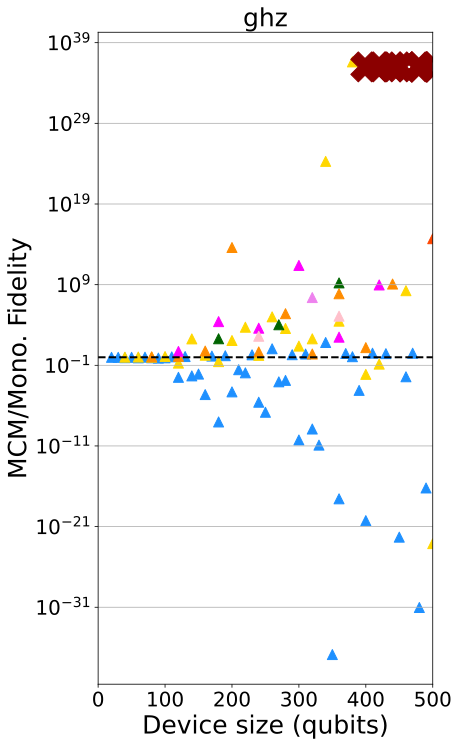

4.54924276053645e+34

In [261]:
bench= 'ghz'
y_axis_bounds = [0.35,10**36]
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(111)
all_data = []
count = 0
for i in ratio_data[bench]:
    ax.scatter(ratio_x_vals[bench][i],ratio_data[bench][i],  s=100, marker='^', color = color_guide[i],label=f'{i} chiplet mcm')
    all_data = all_data+ratio_data[bench][i]
    count=count+1

ax.plot([0,500],[1,1],'--',linewidth=2,color='black')

visited_before = []
one_label = False
for i in lines_no_mono[bench]:
    for j in lines_no_mono[bench][i]:
        if one_label==False:
            ax.scatter([j],[y_axis_bounds[1]],s=900,marker='X',color='darkred',label='zero-yield mono.')
            one_label=True
            visited_before.append(j)
        else:
            move_marker = visited_before.count(j)
            ax.scatter([j],[y_axis_bounds[1]-y_axis_bounds[1]*0.007*move_marker],s=900,marker='X',color='darkred')  
            visited_before.append(j)
            
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('MCM/Mono. Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
#plt.legend(loc='lower left',fontsize=14)
plt.yscale('log')
#plt.ylim(y_axis_bounds)
plt.xlim([0,500])
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.savefig('ghz-all.jpg',bbox_inches = "tight")
plt.show()
np.mean(all_data)

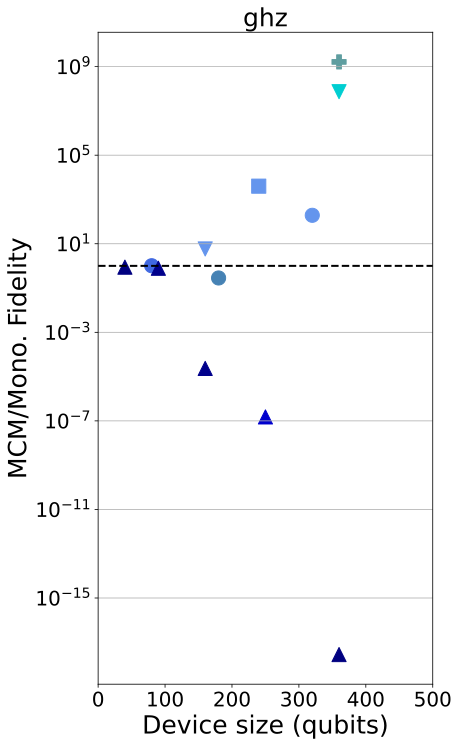

nan

In [295]:
shapes_of_interest = [[2,2],[3,3],[4,4],[5,5],[6,6],[7,7]]
chiplets_of_interest = [10,20,40,60,90]
chip_shapes = {10:'^',20:'o',40:'v',60:'s',90:'P'}
colors_heat = {10:['navy','darkblue','darkblue','mediumblue','navy','midnightblue'],
               20:['royalblue','steelblue','cornflowerblue','royalblue'],
               40:['cornflowerblue','darkturquoise'],
               60:['cornflowerblue'],
               90:['cadetblue']}

bench= 'ghz'
y_axis_bounds = [0.8,10**17]
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(111)
all_data = []
for i in shapes_of_interest:
    #print(i)
    for j in chiplets_of_interest:
        if i == [5,5] and j == 20:
            continue
        if i == [7,7] and j == 10:
            continue
        #print(j)
        tot_qubits_local = i[0]*i[1]*j
        #print(tot_qubits_local)
        if tot_qubits_local in cx_data_all['mono'][bench][j].keys():
            if cx_data_all['mono'][bench][j][tot_qubits_local] != []:
                loc_ratio = cx_data_all['mcm'][bench][j][tot_qubits_local][0]/cx_data_all['mono'][bench][j][tot_qubits_local][0]
                ax.scatter(tot_qubits_local,loc_ratio,  s=200, marker=chip_shapes[j], color = colors_heat[j][i[0]-2])
                
for i in chiplets_of_interest:
    ax.scatter([],[],  s=150, marker=chip_shapes[i], color = 'k',label=f'{i}q chiplet mcm')



ax.plot([0,500],[1,1],'--',linewidth=2,color='black')



            
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('MCM/Mono. Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
#plt.legend(loc='lower left',fontsize=15)
plt.yscale('log')
#plt.ylim(y_axis_bounds)
plt.xlim([0,500])
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.savefig('ghz-focused.jpg',bbox_inches = "tight")
plt.show()
np.mean(all_data)


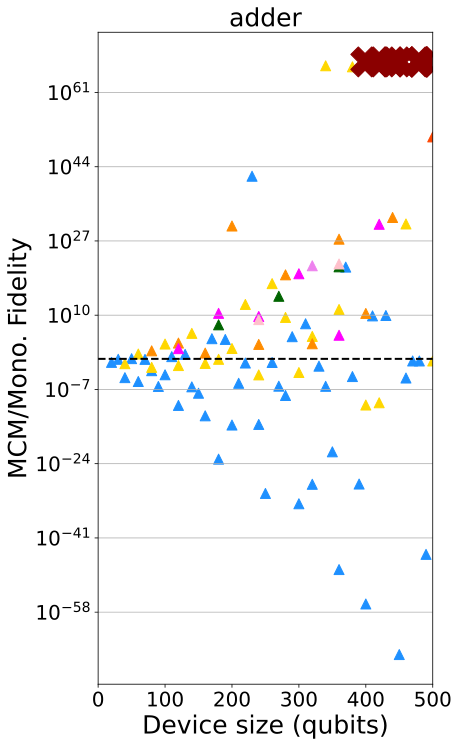

2.2357031900039895e+65

In [263]:
bench= 'adder'
y_axis_bounds = [0.35,10**68]
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(111)
all_data = []
count = 0
for i in ratio_data[bench]:
    ax.scatter(ratio_x_vals[bench][i],ratio_data[bench][i],  s=100, marker='^', color = color_guide[i],label=f'{i} chiplet mcm')
    all_data = all_data+ratio_data[bench][i]
    count=count+1

ax.plot([0,500],[1,1],'--',linewidth=2,color='black')

visited_before = []
one_label = False
for i in lines_no_mono[bench]:
    for j in lines_no_mono[bench][i]:
        if one_label==False:
            ax.scatter([j],[y_axis_bounds[1]],s=900,marker='X',color='darkred',label='zero-yield mono.')
            one_label=True
            visited_before.append(j)
        else:
            move_marker = visited_before.count(j)
            ax.scatter([j],[y_axis_bounds[1]-y_axis_bounds[1]*0.007*move_marker],s=900,marker='X',color='darkred')  
            visited_before.append(j)
            
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('MCM/Mono. Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
#plt.legend(loc='lower left',fontsize=14)
plt.yscale('log')
#plt.ylim(y_axis_bounds)
plt.xlim([0,500])
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.savefig('adder-all.jpg',bbox_inches = "tight")
plt.show()
np.mean(all_data)

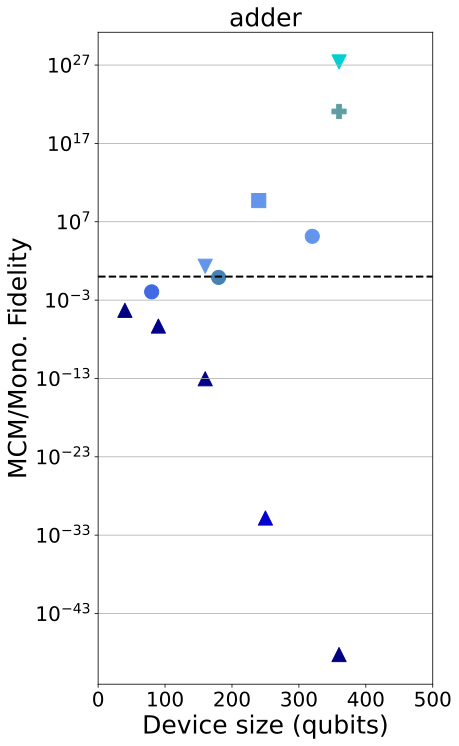

nan

In [296]:
shapes_of_interest = [[2,2],[3,3],[4,4],[5,5],[6,6],[7,7]]
chiplets_of_interest = [10,20,40,60,90]
chip_shapes = {10:'^',20:'o',40:'v',60:'s',90:'P'}
colors_heat = {10:['navy','darkblue','darkblue','mediumblue','navy','midnightblue'],
               20:['royalblue','steelblue','cornflowerblue','royalblue'],
               40:['cornflowerblue','darkturquoise'],
               60:['cornflowerblue'],
               90:['cadetblue']}

bench= 'adder'
y_axis_bounds = [0.8,10**17]
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(111)
all_data = []
for i in shapes_of_interest:
    #print(i)
    for j in chiplets_of_interest:
        if i == [5,5] and j == 20:
            continue
        if i == [7,7] and j == 10:
            continue
        #print(j)
        tot_qubits_local = i[0]*i[1]*j
        #print(tot_qubits_local)
        if tot_qubits_local in cx_data_all['mono'][bench][j].keys():
            if cx_data_all['mono'][bench][j][tot_qubits_local] != []:
                loc_ratio = cx_data_all['mcm'][bench][j][tot_qubits_local][0]/cx_data_all['mono'][bench][j][tot_qubits_local][0]
                ax.scatter(tot_qubits_local,loc_ratio,  s=200, marker=chip_shapes[j], color = colors_heat[j][i[0]-2])
                
for i in chiplets_of_interest:
    ax.scatter([],[],  s=150, marker=chip_shapes[i], color = 'k',label=f'{i}q chiplet mcm')



ax.plot([0,500],[1,1],'--',linewidth=2,color='black')



            
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('MCM/Mono. Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
#plt.legend(loc='lower left',fontsize=15)
plt.yscale('log')
#plt.ylim(y_axis_bounds)
plt.xlim([0,500])
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.savefig('adder-focused.jpg',bbox_inches = "tight")
plt.show()
np.mean(all_data)



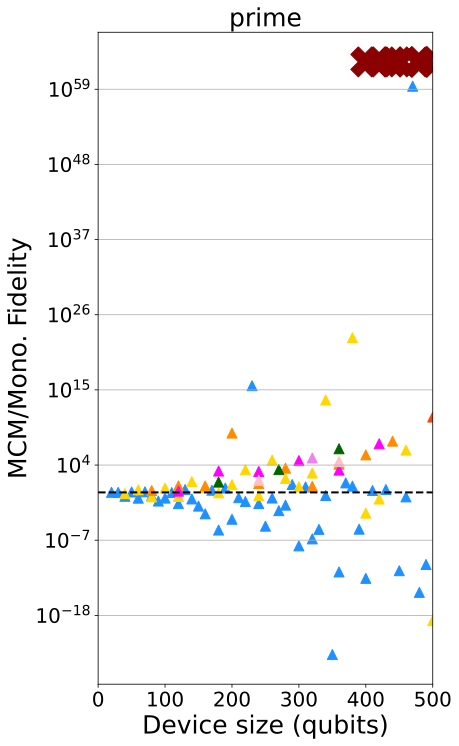

3.0422589823291842e+57

In [290]:
bench= 'prime'
y_axis_bounds = [0.35,10**63]
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(111)
all_data = []
count = 0
for i in ratio_data[bench]:
    ax.scatter(ratio_x_vals[bench][i],ratio_data[bench][i],  s=100, marker='^', color = color_guide[i],label=f'{i} chiplet mcm')
    all_data = all_data+ratio_data[bench][i]
    count=count+1

ax.plot([0,500],[1,1],'--',linewidth=2,color='black')

visited_before = []
one_label = False
for i in lines_no_mono[bench]:
    for j in lines_no_mono[bench][i]:
        if one_label==False:
            ax.scatter([j],[y_axis_bounds[1]],s=900,marker='X',color='darkred',label='zero-yield mono.')
            one_label=True
            visited_before.append(j)
        else:
            move_marker = visited_before.count(j)
            ax.scatter([j],[y_axis_bounds[1]-y_axis_bounds[1]*0.007*move_marker],s=900,marker='X',color='darkred')  
            visited_before.append(j)
            
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('MCM/Mono. Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
#plt.legend(loc='lower left',fontsize=14)
plt.yscale('log')
#plt.ylim(y_axis_bounds)
plt.xlim([0,500])
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.savefig('prime-all.jpg',bbox_inches = "tight")
plt.show()
np.mean(all_data)

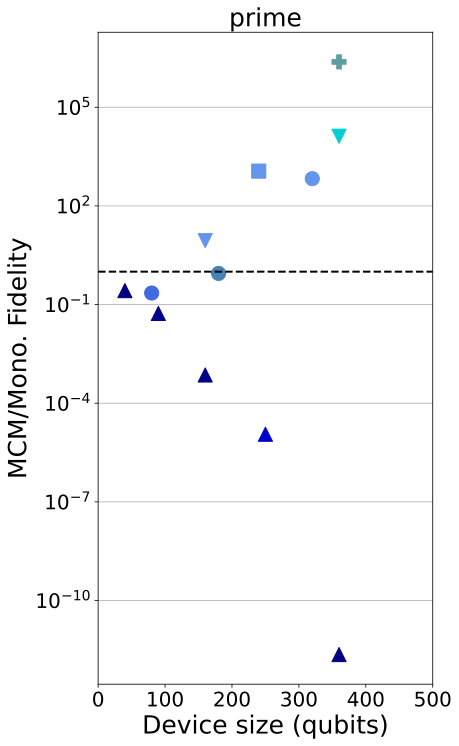

nan

In [297]:
shapes_of_interest = [[2,2],[3,3],[4,4],[5,5],[6,6],[7,7]]
chiplets_of_interest = [10,20,40,60,90]
chip_shapes = {10:'^',20:'o',40:'v',60:'s',90:'P'}
colors_heat = {10:['navy','darkblue','darkblue','mediumblue','navy','midnightblue'],
               20:['royalblue','steelblue','cornflowerblue','royalblue'],
               40:['cornflowerblue','darkturquoise'],
               60:['cornflowerblue'],
               90:['cadetblue']}

bench= 'prime'
y_axis_bounds = [0.8,10**17]
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(111)
all_data = []
for i in shapes_of_interest:
    #print(i)
    for j in chiplets_of_interest:
        if i == [5,5] and j == 20:
            continue
        if i == [7,7] and j == 10:
            continue
        #print(j)
        tot_qubits_local = i[0]*i[1]*j
        #print(tot_qubits_local)
        if tot_qubits_local in cx_data_all['mono'][bench][j].keys():
            if cx_data_all['mono'][bench][j][tot_qubits_local] != []:
                loc_ratio = cx_data_all['mcm'][bench][j][tot_qubits_local][0]/cx_data_all['mono'][bench][j][tot_qubits_local][0]
                ax.scatter(tot_qubits_local,loc_ratio,  s=200, marker=chip_shapes[j], color = colors_heat[j][i[0]-2])
                
for i in chiplets_of_interest:
    ax.scatter([],[],  s=150, marker=chip_shapes[i], color = 'k',label=f'{i}q chiplet mcm')



ax.plot([0,500],[1,1],'--',linewidth=2,color='black')



            
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('MCM/Mono. Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
#plt.legend(loc='lower left',fontsize=15)
plt.yscale('log')
#plt.ylim(y_axis_bounds)
plt.xlim([0,500])
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.savefig('prime-focused.jpg',bbox_inches = "tight")
plt.show()
np.mean(all_data)


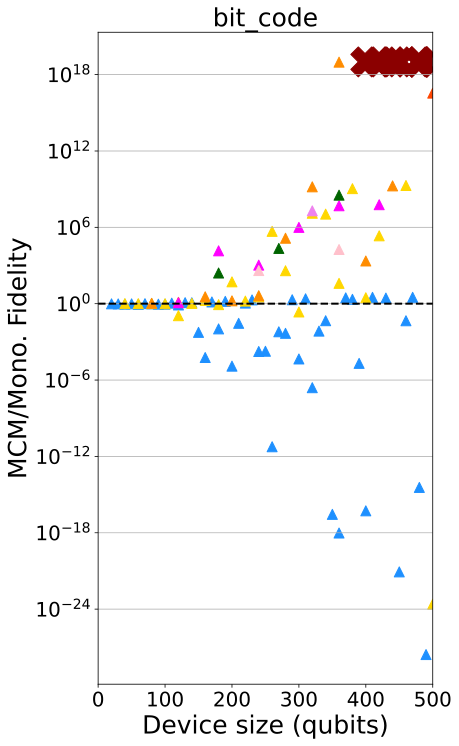

1.0529150717907117e+17

In [267]:
bench= 'bit_code'
y_axis_bounds = [0.35,10**19]
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(111)
all_data = []
count = 0
for i in ratio_data[bench]:
    ax.scatter(ratio_x_vals[bench][i],ratio_data[bench][i],  s=100, marker='^', color = color_guide[i],label=f'{i} chiplet mcm')
    all_data = all_data+ratio_data[bench][i]
    count=count+1

ax.plot([0,500],[1,1],'--',linewidth=2,color='black')

visited_before = []
one_label = False
for i in lines_no_mono[bench]:
    for j in lines_no_mono[bench][i]:
        if one_label==False:
            ax.scatter([j],[y_axis_bounds[1]],s=900,marker='X',color='darkred',label='zero-yield mono.')
            one_label=True
            visited_before.append(j)
        else:
            move_marker = visited_before.count(j)
            ax.scatter([j],[y_axis_bounds[1]-y_axis_bounds[1]*0.007*move_marker],s=900,marker='X',color='darkred')  
            visited_before.append(j)
            
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('MCM/Mono. Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
#plt.legend(loc='lower left',fontsize=14)
plt.yscale('log')
#plt.ylim(y_axis_bounds)
plt.xlim([0,500])
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.savefig('bit_code-all.jpg',bbox_inches = "tight")
plt.show()
np.mean(all_data)

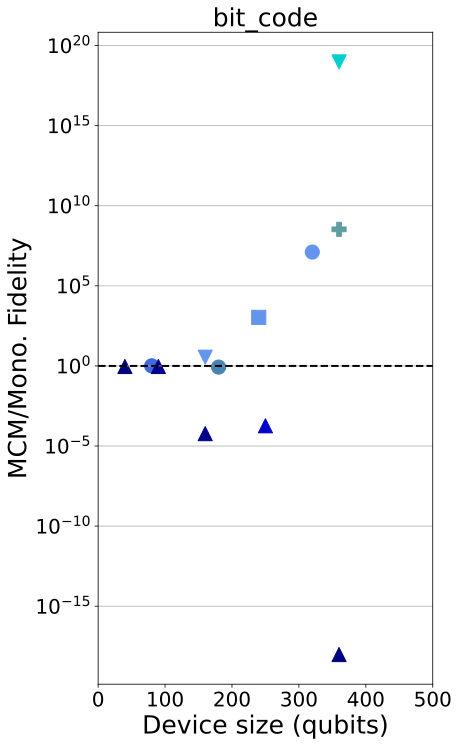

nan

In [298]:
shapes_of_interest = [[2,2],[3,3],[4,4],[5,5],[6,6],[7,7]]
chiplets_of_interest = [10,20,40,60,90]
chip_shapes = {10:'^',20:'o',40:'v',60:'s',90:'P'}
colors_heat = {10:['navy','darkblue','darkblue','mediumblue','navy','midnightblue'],
               20:['royalblue','steelblue','cornflowerblue','royalblue'],
               40:['cornflowerblue','darkturquoise'],
               60:['cornflowerblue'],
               90:['cadetblue']}

bench= 'bit_code'
y_axis_bounds = [0.8,10**17]
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(111)
all_data = []
for i in shapes_of_interest:
    #print(i)
    for j in chiplets_of_interest:
        if i == [5,5] and j == 20:
            continue
        if i == [7,7] and j == 10:
            continue
        #print(j)
        tot_qubits_local = i[0]*i[1]*j
        #print(tot_qubits_local)
        if tot_qubits_local in cx_data_all['mono'][bench][j].keys():
            if cx_data_all['mono'][bench][j][tot_qubits_local] != []:
                loc_ratio = cx_data_all['mcm'][bench][j][tot_qubits_local][0]/cx_data_all['mono'][bench][j][tot_qubits_local][0]
                ax.scatter(tot_qubits_local,loc_ratio,  s=200, marker=chip_shapes[j], color = colors_heat[j][i[0]-2])
                
for i in chiplets_of_interest:
    ax.scatter([],[],  s=150, marker=chip_shapes[i], color = 'k',label=f'{i}q chiplet mcm')



ax.plot([0,500],[1,1],'--',linewidth=2,color='black')



            
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('MCM/Mono. Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
#plt.legend(loc='lower left',fontsize=15)
plt.yscale('log')
#plt.ylim(y_axis_bounds)
plt.xlim([0,500])
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.savefig('bit_code-focused.jpg',bbox_inches = "tight")
plt.show()
np.mean(all_data)


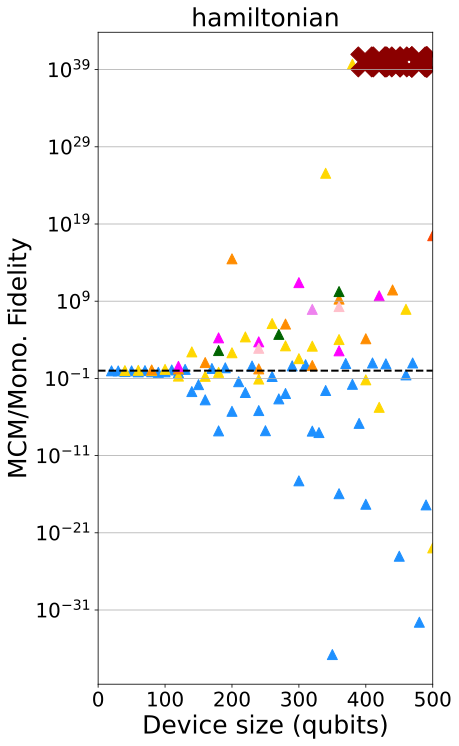

5.538697923563639e+37

In [292]:
bench= 'hamiltonian'
y_axis_bounds = [0.35,10**40]
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(111)
all_data = []
count = 0
for i in ratio_data[bench]:
    ax.scatter(ratio_x_vals[bench][i],ratio_data[bench][i],  s=100, marker='^', color = color_guide[i],label=f'{i} chiplet mcm')
    all_data = all_data+ratio_data[bench][i]
    count=count+1

ax.plot([0,500],[1,1],'--',linewidth=2,color='black')

visited_before = []
one_label = False
for i in lines_no_mono[bench]:
    for j in lines_no_mono[bench][i]:
        if one_label==False:
            ax.scatter([j],[y_axis_bounds[1]],s=900,marker='X',color='darkred',label='zero-yield mono.')
            one_label=True
            visited_before.append(j)
        else:
            move_marker = visited_before.count(j)
            ax.scatter([j],[y_axis_bounds[1]-y_axis_bounds[1]*0.007*move_marker],s=900,marker='X',color='darkred')  
            visited_before.append(j)
            
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('MCM/Mono. Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
#plt.legend(loc='lower left',fontsize=14)
plt.yscale('log')
#plt.ylim(y_axis_bounds)
plt.xlim([0,500])
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.savefig('hamiltonian-all.jpg',bbox_inches = "tight")
plt.show()
np.mean(all_data)

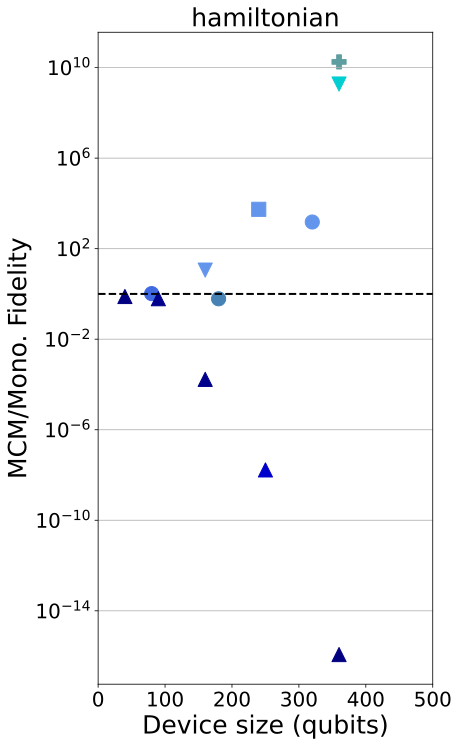

nan

In [299]:
shapes_of_interest = [[2,2],[3,3],[4,4],[5,5],[6,6],[7,7]]
chiplets_of_interest = [10,20,40,60,90]
chip_shapes = {10:'^',20:'o',40:'v',60:'s',90:'P'}
colors_heat = {10:['navy','darkblue','darkblue','mediumblue','navy','midnightblue'],
               20:['royalblue','steelblue','cornflowerblue','royalblue'],
               40:['cornflowerblue','darkturquoise'],
               60:['cornflowerblue'],
               90:['cadetblue']}

bench= 'hamiltonian'
y_axis_bounds = [0.8,10**17]
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(111)
all_data = []
for i in shapes_of_interest:
    #print(i)
    for j in chiplets_of_interest:
        if i == [5,5] and j == 20:
            continue
        if i == [7,7] and j == 10:
            continue
        #print(j)
        tot_qubits_local = i[0]*i[1]*j
        #print(tot_qubits_local)
        if tot_qubits_local in cx_data_all['mono'][bench][j].keys():
            if cx_data_all['mono'][bench][j][tot_qubits_local] != []:
                loc_ratio = cx_data_all['mcm'][bench][j][tot_qubits_local][0]/cx_data_all['mono'][bench][j][tot_qubits_local][0]
                ax.scatter(tot_qubits_local,loc_ratio,  s=200, marker=chip_shapes[j], color = colors_heat[j][i[0]-2])
                
for i in chiplets_of_interest:
    ax.scatter([],[],  s=150, marker=chip_shapes[i], color = 'k',label=f'{i}q chiplet mcm')



ax.plot([0,500],[1,1],'--',linewidth=2,color='black')



            
plt.title(f'{bench}',fontsize=25)
ax.set_ylabel('MCM/Mono. Fidelity',fontsize=25)
ax.set_xlabel('Device size (qubits)',fontsize=25)
#plt.legend(loc='lower left',fontsize=15)
plt.yscale('log')
#plt.ylim(y_axis_bounds)
plt.xlim([0,500])
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
plt.savefig('hamiltonian-focused.jpg',bbox_inches = "tight")
plt.show()
np.mean(all_data)


### Part 11: Yield analysis.

In [126]:
mono_yields_all = []
for i in mono_yields:
    for j in mono_yields[i]:
        mono_yields_all.append([j,mono_yields[i][j]])

for i in chip_yields:
    mono_yields_all.append([i,chip_yields[i]])
mono_yields_all.sort()

In [127]:
mono_x_vals = []
mono_y_vals = []
for i in mono_yields_all:
    mono_x_vals.append(i[0])
    mono_y_vals.append(i[1])
model_mono = np.poly1d(np.polyfit(mono_x_vals, mono_y_vals, 6))

In [128]:
bumps_per_qubit = 25
success_per_bump = 0.99999960642

scale_factor = 100
success_per_bump_scaled = 1- (1-success_per_bump)*scale_factor
mcm_yield_scaling = success_per_bump**25
mcm_yield_scaling_w_scale = success_per_bump_scaled**25

data_mcm_yield_plot_scaled = {}
data_mcm_yield_plot = {}

for i in chip_yields:
    data_mcm_yield_plot[i]=[[i,chip_yields[i]]]
    data_mcm_yield_plot_scaled[i]=[[i,chip_yields[i]]]
    
    for j in mcm_dict[i]:
        temp_tot_qubits = j['tot_qubits']
        temp_local_yield = j['dim'][0]*j['dim'][1]*len(j['mcms'])/n_samples
        temp_total_link_qubits = len(j['mcms'][0].link_list)
        temp_local_mcm_scale = mcm_yield_scaling**temp_total_link_qubits
        #data_mcm_yield_plot[i].append([temp_tot_qubits,chip_yields[i]*temp_local_mcm_scale])
        
        data_mcm_yield_plot[i].append([temp_tot_qubits,temp_local_yield*temp_local_mcm_scale])
        data_mcm_yield_plot_scaled[i].append([temp_tot_qubits,temp_local_yield*(mcm_yield_scaling_w_scale**temp_total_link_qubits)])
        
    
    data_mcm_yield_plot[i].sort()
    data_mcm_yield_plot_scaled[i].sort()



all mono
0.07565045045045043

10
0.8443805752181406
corresponding mono:
0.07982857142857142
relative improvement 9.577423

20
0.6926257804342617
corresponding mono:
0.05609166666666667
relative improvement 11.348105

40
0.4631838040391436
corresponding mono:
0.032045454545454544
relative improvement 13.453963

60
0.3111028640894721
corresponding mono:
0.01774285714285714
relative improvement 16.533978

90
0.1634186288414419
corresponding mono:
0.0068000000000000005
relative improvement 23.032151

120
0.08281591867698808
corresponding mono:
0.0026333333333333334
relative improvement 30.449083

160
0.037445576450207796
corresponding mono:
0.0004
relative improvement 92.613941

200
0.013398681571604868
corresponding mono:
0.0
relative improvement inf

250
0.005399468693034797
corresponding mono:
0.0001
relative improvement 52.994687



/Users/katesmith/opt/anaconda3/envs/supermarqEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/katesmith/opt/anaconda3/envs/supermarqEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/katesmith/opt/anaconda3/envs/supermarqEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/katesmith/opt/anaconda3/envs/supermarqEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/katesmith/opt/anaconda3/envs/supermarqEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3369: RankWarning: Polyfit may

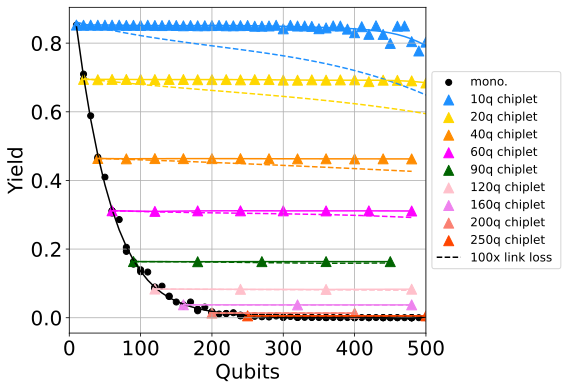

In [135]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.scatter(mono_x_vals,mono_y_vals,  s=150, marker='.', color ='k',label='mono.')
ax.plot(mono_x_vals,model_mono(mono_x_vals),color='k')
color_guide = {10:'dodgerblue',20:'gold',40:'darkorange',60:'magenta',90:'darkgreen',120:'pink',160:'violet',200:'salmon',250:'orangered'}
print('all mono')
print(np.mean(mono_y_vals))
print()

for i in data_mcm_yield_plot:
    temp_x_data = []
    temp_y_data = []
    for j in data_mcm_yield_plot[i]:
        temp_x_data.append(j[0])
        temp_y_data.append(j[1])
        
    
    #ax.plot(temp_x_data,temp_y_data,marker='^',color=color_guide[i],label=f'{i}q chiplet')
    temp_model = np.poly1d(np.polyfit(temp_x_data, temp_y_data, 6))
    ax.scatter(temp_x_data,temp_y_data,s=100,marker='^',color=color_guide[i],label=f'{i}q chiplet')
    ax.plot(temp_x_data,temp_model(temp_x_data),color=color_guide[i])
    print(i)
    
    del temp_y_data[0]
    print(np.mean(temp_y_data))
    separate_corresponding_mono = []
    for j in mono_yields[i]:
        separate_corresponding_mono.append(mono_yields[i][j])
    print('corresponding mono:')
    print(np.mean(separate_corresponding_mono))
    print('relative improvement %f'%((np.mean(temp_y_data)-np.mean(separate_corresponding_mono))/np.mean(separate_corresponding_mono)))
    print()
    
    temp_x_data = []
    temp_y_data = []
    for j in data_mcm_yield_plot_scaled[i]:
        temp_x_data.append(j[0])
        temp_y_data.append(j[1])
    temp_model = np.poly1d(np.polyfit(temp_x_data, temp_y_data, 3))
    ax.plot(temp_x_data,temp_model(temp_x_data),linestyle='dashed',color=color_guide[i])
    
    
ax.plot([],[],linestyle='dashed',color='k',label=f'{scale_factor}x link loss ')

ax.set_ylabel('Yield',fontsize=20)
ax.set_xlabel('Qubits',fontsize=20)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)

#plt.legend(loc='upper left',fontsize=14)
ax.set_xticks(np.arange(0, 501, 100))
plt.xlim([0,500])
ax.yaxis.set_tick_params(labelsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.grid(axis='y')
ax.grid(axis='x')
plt.show()

In [256]:
mono_yields_all

[[10, 0.8527],
 [20, 0.6945],
 [20, 0.7098],
 [30, 0.5885],
 [40, 0.4597],
 [40, 0.4639],
 [40, 0.4678],
 [50, 0.4095],
 [60, 0.305],
 [60, 0.3115],
 [60, 0.3116],
 [70, 0.286],
 [80, 0.1932],
 [80, 0.1998],
 [80, 0.2052],
 [90, 0.1561],
 [90, 0.1636],
 [100, 0.134],
 [100, 0.1398],
 [110, 0.1331],
 [120, 0.083],
 [120, 0.0835],
 [120, 0.0871],
 [120, 0.0886],
 [120, 0.0895],
 [130, 0.092],
 [140, 0.0618],
 [140, 0.0631],
 [150, 0.0458],
 [160, 0.0341],
 [160, 0.0342],
 [160, 0.0352],
 [160, 0.0377],
 [170, 0.0458],
 [180, 0.0202],
 [180, 0.0236],
 [180, 0.0238],
 [180, 0.0244],
 [190, 0.0311],
 [200, 0.0137],
 [200, 0.014],
 [200, 0.0142],
 [200, 0.0176],
 [210, 0.0108],
 [220, 0.012],
 [220, 0.0124],
 [230, 0.0146],
 [240, 0.0054],
 [240, 0.0062],
 [240, 0.0065],
 [240, 0.0073],
 [240, 0.0073],
 [250, 0.0055],
 [250, 0.0057],
 [260, 0.0043],
 [260, 0.0052],
 [270, 0.0029],
 [270, 0.0032],
 [280, 0.0023],
 [280, 0.0029],
 [280, 0.0042],
 [290, 0.005],
 [300, 0.0009],
 [300, 0.001],
 [

In [132]:
data_mcm_yield_plot

{10: [[10, 0.8527],
  [20, 0.8521832297179099],
  [30, 0.8525664440229458],
  [40, 0.8522993596442071],
  [50, 0.8524328972378536],
  [60, 0.8524322333209132],
  [70, 0.8524993360307965],
  [80, 0.8517653011737434],
  [90, 0.851998149994083],
  [100, 0.8516982562418852],
  [110, 0.8523322529979809],
  [120, 0.8515809403093918],
  [130, 0.8512989436788736],
  [140, 0.852163875295723],
  [150, 0.8514636405364102],
  [160, 0.8505971859037424],
  [170, 0.8514318724924749],
  [180, 0.8507468172327421],
  [190, 0.8508985395693576],
  [200, 0.851229089460079],
  [210, 0.8518285465653327],
  [220, 0.8506965931655586],
  [230, 0.8506316494317102],
  [240, 0.8510615925359871],
  [250, 0.8514940129733725],
  [260, 0.8493638569743014],
  [270, 0.8494963730602384],
  [280, 0.8500951669473075],
  [290, 0.8521303364833305],
  [300, 0.8417898432245026],
  [310, 0.851996858010521],
  [320, 0.8499278931459158],
  [330, 0.8501610542355257],
  [340, 0.8488967245127013],
  [350, 0.8420736726745227],
  [360

In [133]:
data_mcm_yield_plot_scaled

{10: [[10, 0.8527],
  [20, 0.8505245717272325],
  [30, 0.8492508660956739],
  [40, 0.842394361869122],
  [50, 0.8458156721504173],
  [60, 0.835985373448074],
  [70, 0.8425920142299547],
  [80, 0.8288468394132241],
  [90, 0.8226375316825559],
  [100, 0.8223479725372963],
  [110, 0.8358873221492882],
  [120, 0.8110973295108423],
  [130, 0.8316271766238795],
  [140, 0.8100727815669082],
  [150, 0.8000006079054118],
  [160, 0.792982635680882],
  [170, 0.8253003102372943],
  [180, 0.7885000288737397],
  [190, 0.821575814816604],
  [200, 0.7782605344965476],
  [210, 0.7788086052954889],
  [220, 0.7838585842428132],
  [230, 0.8149424331451603],
  [240, 0.7630945620114872],
  [250, 0.7575555632418713],
  [260, 0.7705269870730357],
  [270, 0.755778306788518],
  [280, 0.7475215711487613],
  [290, 0.8068907006172044],
  [300, 0.7301919398581238],
  [310, 0.8036268522540143],
  [320, 0.7329546092156793],
  [330, 0.7360180092794907],
  [340, 0.7464677343473298],
  [350, 0.7121703735075802],
  [360,

### Part 12: Mapped circuit composition.

In [122]:
sizes_of_interest = {10:40 , 20:80 , 40:160, 60:240 , 90:360}
for i in sizes_of_interest:
    print(i)
    for j in mapped_circuits['mcm'].keys():
        temp = mapped_circuits['mcm'][j][i][sizes_of_interest[i]][0].count_ops()
        cx_gates = temp['cx']
        one_q_gates = 0
        if 'x' in temp.keys():
            one_q_gates = one_q_gates + temp['x']
        if 'sx' in temp.keys():
            one_q_gates = one_q_gates + temp['sx']
        if 'rz' in temp.keys():
            one_q_gates = one_q_gates + temp['rz']
            
        cx_critical = circuit_to_dag(mapped_circuits['mcm'][j][i][sizes_of_interest[i]][0]).count_ops_longest_path()['cx'] 
        print(j + ':   ' +f'{one_q_gates}/{cx_gates}/{cx_critical}' )

10
bv:   192/437/228
ghz:   3/31/31
qaoa:   34/62/33
adder:   390/1339/750
prime:   226/315/74
bit_code:   16/30/30
hamiltonian:   191/62/62
20
bv:   384/1193/604
ghz:   3/63/63
qaoa:   66/126/65
adder:   806/3741/1881
prime:   461/890/88
bit_code:   32/62/62
hamiltonian:   383/126/126
40
bv:   768/2251/1135
ghz:   3/2170/1147
qaoa:   130/3691/1263
adder:   1638/6915/3695
prime:   927/1552/114
bit_code:   64/2557/1313
hamiltonian:   767/2320/1267
60
bv:   1152/5865/2952
ghz:   3/6081/3105
qaoa:   195/9320/3245
adder:   2470/16164/7654
prime:   1380/4690/300
bit_code:   96/3804/1973
hamiltonian:   1151/6241/3235
90
bv:   1728/6393/3282
ghz:   3/5977/3112
qaoa:   291/10410/3413
adder:   3717/19682/9818
prime:   2073/4382/205
bit_code:   144/6016/3133
hamiltonian:   1727/6455/3480


In [288]:
tot_mono_zero_yield = 0
for i in mono_yields:
    for j in mono_yields[i]:
        if mono_yields[i][j] == 0:
            tot_mono_zero_yield = tot_mono_zero_yield + 1
            
print(f'Total zero yield mono: {tot_mono_zero_yield}')

Total zero yield mono: 11
